# EBM Training on Google Colab Pro+ (A100)

This notebook trains an Energy-Based Model (EBM) to learn the energy landscape of UC/DR/Storage binary variables from MILP solutions, conditioned on Hierarchical Temporal Encoder embeddings.

## Hardware Requirements
- **GPU**: A100 (40 or 80 GB VRAM)
- **RAM**: 50+ GB (High RAM runtime)
- **Storage**: 100+ GB on Drive

## Setup
1. Upload your `benchmark` repo to Google Drive
2. Select Runtime → Change runtime type → A100 GPU + High RAM
3. Run cells in order

---

## 1. Mount Google Drive and Setup Paths

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

# Set paths - ADJUST THIS to match your Drive structure
REPO_PATH = '/content/drive/MyDrive/benchmark'
EMBEDDING_FILE = 'outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt'
SCENARIOS_DIR = 'outputs/scenarios_v1_filtered'
SCENARIO_DIR_EVAL = 'outputs/scenarios_v1/eval'
OUTPUT_DIR = 'outputs/ebm_models'

# Add repo to Python path
sys.path.insert(0, REPO_PATH)

# Verify paths exist
print(f"Repo path: {REPO_PATH}")
print(f"Repo exists: {os.path.exists(REPO_PATH)}")
print(f"Embeddings path: {os.path.join(REPO_PATH, EMBEDDING_FILE)}")
print(f"Embeddings exist: {os.path.exists(os.path.join(REPO_PATH, EMBEDDING_FILE))}")
print(f"Scenarios exist: {os.path.exists(os.path.join(REPO_PATH, SCENARIOS_DIR))}")
print(f"Scenario EVAL: {os.path.exists(os.path.join(REPO_PATH, SCENARIO_DIR_EVAL))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Repo path: /content/drive/MyDrive/benchmark
Repo exists: True
Embeddings path: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_flat.pt
Embeddings exist: True
Scenarios exist: True
Scenario EVAL: True


## 2. Install Dependencies

In [2]:
# Install required packages
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install -q torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install -q wandb tqdm pandas numpy scipy

import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q wandb numpy scipy tqdm pandas thrml

print("✓ Dependencies installed")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 120.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8

## 3. Check GPU and System Info

In [2]:
import torch
import subprocess

# Check GPU
print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)

# GPU Info
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")

    # Verify it's A100
    if 'A100' in gpu_name:
        print("✓ A100 GPU detected!")
    else:
        print(f"⚠️  Warning: Expected A100, got {gpu_name}")
        print("   Change runtime: Runtime → Change runtime type → A100")
else:
    print("❌ No GPU detected!")
    print("   Enable GPU: Runtime → Change runtime type → GPU")

# RAM Info
try:
    mem_info = !cat /proc/meminfo | grep MemTotal
    mem_gb = int(mem_info[0].split()[1]) / 1e6
    print(f"\nRAM: {mem_gb:.1f} GB")
    if mem_gb > 45:
        print("✓ High RAM runtime detected!")
    else:
        print("⚠️  Consider using High RAM runtime for better performance")
except:
    print("\nCouldn't detect RAM")

# Disk Space
disk_info = !df -h /content
print(f"\nDisk Space:\n{disk_info[1]}")

print("=" * 60)

SYSTEM INFORMATION
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB
CUDA Version: 12.4
PyTorch Version: 2.5.1+cu124
✓ A100 GPU detected!

RAM: 175.2 GB
✓ High RAM runtime detected!

Disk Space:
overlay         236G   47G  190G  20% /


## 4. Import EBM Modules

In [3]:
import os

os.chdir(REPO_PATH)

from torch.utils.data import DataLoader, random_split, Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import global_add_pool
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime

from src.ebm import (
    EnergyModel,
    StructuredEnergyModel,
    GibbsSampler,
    SGLDSampler,
    # PersistentContrastiveDivergence, # Removed due to ImportError
    MILPBinaryDataset,
    EBMTrainer,
    # ScheduledEBMTrainer,
    EBMMetrics,
    # TemporalMetrics,
    EmbeddingLoader,
    # collate_ebm_batch,
)

from src.ebm.model import GraphEnergyModel
from src.ebm.sampler import PersistentContrastiveDivergence, GraphSampler
from src.ebm.dataset import collate_ebm_batch, GraphBinaryDataset
from src.ebm.trainer import EBMTrainer, ScheduledEBMTrainer
from src.ebm.metrics import TemporalMetrics

print("✓ Modules imported successfully")

✓ Modules imported successfully


## 5. Configuration

In [ ]:
# Training Configuration
import shutil

# Define paths
drive_embedding_path = os.path.join(REPO_PATH, EMBEDDING_FILE)
local_embedding_path = '/content/embeddings_multiscale_normalized.pt'

# Copy file if not present locally
if not os.path.exists(local_embedding_path):
    print(f"🔄 Copying embeddings to local disk for faster I/O...")
    print(f"   Source: {drive_embedding_path}")
    print(f"   Dest:   {local_embedding_path}")
    print("   ⏳ This may take 1 minute...")
    shutil.copy(drive_embedding_path, local_embedding_path)
    print("   ✓ Copy complete!")
else:
    print(f"✓ Embeddings already found locally: {local_embedding_path}")

CONFIG = {
    # Data
    'scenarios_dir': os.path.join(REPO_PATH, SCENARIOS_DIR),
    'scenarios_dir_eval': os.path.join(REPO_PATH, SCENARIO_DIR_EVAL),
    'embedding_file': local_embedding_path, # Updated to local path
    'output_dir': os.path.join(REPO_PATH, OUTPUT_DIR),

    # Model
    'model_type': 'structured',  # 'basic', 'structured', or 'factorized'
    'hidden_dims': [256, 256, 64],
    'use_quadratic': True,
    'quadratic_rank': 16,
    'activation': 'gelu',
    'dropout': 0.1,

    # Data loading
    'embedding_loading_mode': 'full',  # 'full' or 'lazy' - use full on A100!
    'temporal': False,  # Set True for temporal EBM
    'temporal_aggregation': 'mean',  # 'mean', 'max', 'last', 'first'

    # Training
    'batch_size': 128,  # Large batches for A100
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'gradient_clip': 1.0,

    # Sampling
    'sampler_type': 'pcd',  # 'gibbs', 'sgld', or 'pcd'
    'num_gibbs_steps': 5,  # Reduced from 50 to 5 for PCD (10x speedup)
    'temperature': 1.0,
    'initial_temperature': 2.0,
    'final_temperature': 1.0,
    'use_pcd': True,
    'num_pcd_chains': 128, # Reduced from 2000 to 128 to fix latency bottleneck

    # Training dynamics
    'num_negative_samples': 1,
    'use_amp': True,  # Mixed precision for A100
    'num_workers': 0,  # Parallel data loading

    # Evaluation
    'validate_every': 5,
    'save_every': 10,

    # Logging
    'use_wandb': False,  # Set True to log to W&B
    'wandb_project': 'milp-ebm',
    'wandb_name': f'ebm_a100_{datetime.now().strftime("%Y%m%d_%H%M%S")}',

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
}

# Set random seed
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# Print configuration
print("\n" + "=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
for key, value in CONFIG.items():
    if not key.startswith('_'):
        print(f"{key:25s}: {value}")
print("=" * 60 + "\n")

🔄 Copying embeddings to local disk for faster I/O...
   Source: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_flat.pt
   Dest:   /content/embeddings_flat.pt
   ⏳ This may take 1 minute...
   ✓ Copy complete!

TRAINING CONFIGURATION
scenarios_dir            : /content/drive/MyDrive/benchmark/outputs/scenarios_v1
scenarios_dir_eval       : /content/drive/MyDrive/benchmark/outputs/scenarios_v1/eval
embedding_file           : /content/embeddings_flat.pt
output_dir               : /content/drive/MyDrive/benchmark/outputs/ebm_models
model_type               : structured
hidden_dims              : [256, 256, 64]
use_quadratic            : True
quadratic_rank           : 16
activation               : gelu
dropout                  : 0.1
embedding_loading_mode   : full
temporal                 : False
temporal_aggregation     : mean
batch_size               : 128
num_epochs               : 100
learning_rate            : 0.0001
weight_decay             : 1e-05

## 6. Load Dataset with Full Embeddings

In [5]:
# Clear RAM
import gc
gc.collect()

# Define dummy class to handle legacy pickle data
class TrainingConfig:
    pass

print("Loading dataset...")
print(f"Embedding loading mode: {CONFIG['embedding_loading_mode']}")
print("⏳ This may take 1 minutes for full loading...\n")

dataset = MILPBinaryDataset(
    scenarios_dir=CONFIG['scenarios_dir'],
    embedding_file=CONFIG['embedding_file'],
    embedding_loading_mode=CONFIG['embedding_loading_mode'],
    temporal=CONFIG['temporal'],
    temporal_aggregation=CONFIG['temporal_aggregation'],
    device='cpu',  # Keep on CPU, move to GPU in batches
)

# --- FILTER DATASET TO MATCH EMBEDDINGS ---
if hasattr(dataset, 'embedding_loader') and hasattr(dataset.embedding_loader, 'keys'):
    valid_keys = set(dataset.embedding_loader.keys)
    print(f"\n🔍 Found {len(valid_keys)} embeddings in file.")

    if len(valid_keys) > 0 and len(valid_keys) < len(dataset):
        print(f"⚠️ Dataset has {len(dataset)} scenarios, but only {len(valid_keys)} embeddings found.")
        print("🧹 Filtering dataset to match available embeddings...")

        # Filter scenarios (handling potential filename extensions)
        valid_scenarios = []
        for s in dataset.scenarios:
            # key might be the filename or filename without extension
            key = os.path.splitext(s)[0]
            if key in valid_keys or s in valid_keys:
                valid_scenarios.append(s)

        dataset.scenarios = valid_scenarios
        print(f"✓ Filtered down to {len(dataset)} scenarios.")
    elif len(valid_keys) == 0:
        print("❌ No embeddings found in loader keys! Check the file structure.")
    else:
        print("✓ All scenarios have embeddings.")
else:
    print("⚠️ Could not check embedding keys (loader might not expose them).")
# ------------------------------------------

print(f"\n✓ Dataset loaded: {len(dataset)} scenarios")

if len(dataset) > 0:
    # Get sample to determine dimensions
    sample = dataset[0]
    dim_u = sample['u'].shape[0]
    dim_h = sample['h'].shape[0]

    print(f"Binary dimension (dim_u): {dim_u}")
    print(f"Embedding dimension (dim_h): {dim_h}")
    print(f"Sample scenario: {sample['scenario_id']}")
    print(f"Binary vars shape: {sample['u'].shape}")
    print(f"Embedding shape: {sample['h'].shape}")

    # Check if embeddings are real (not random)
    h_mean = sample['h'].mean().item()
    h_std = sample['h'].std().item()
    print(f"\nEmbedding stats: mean={h_mean:.4f}, std={h_std:.4f}")
    if abs(h_mean) < 0.1 and abs(h_std - 1.0) < 0.2:
        print("⚠️  Warning: Embeddings look like random noise!")
    else:
        print("✓ Real embeddings detected")
else:
    print("❌ Dataset is empty after filtering!")

Loading dataset...
Embedding loading mode: full
⏳ This may take 1 minutes for full loading...


Initializing embedding loader from: /content/embeddings_flat.pt
Found embeddings at: /content/embeddings_flat.pt
Initializing EmbeddingLoader for /content/embeddings_flat.pt
File size: 0.10 GB
Loading mode: full
Loading full embeddings file (this may take a while)...


/content/drive/MyDrive/benchmark/src/ebm/embedding_loader.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.embedding_file, map_location=self.devic

Loaded direct mapping with 2000 scenarios
Sample embedding shape: torch.Size([96, 128])
Sample embedding dtype: torch.float32
Total scenarios: 2000
Embeddings already on CPU
Embedding loader initialized with 2000 scenarios
Loaded 2000 scenarios from /content/drive/MyDrive/benchmark/outputs/scenarios_v1
Binary variables per scenario: 9600
Timesteps: 96
⚠️ Could not check embedding keys (loader might not expose them).

✓ Dataset loaded: 2000 scenarios
Binary dimension (dim_u): 59808
Embedding dimension (dim_h): 128
Sample scenario: scenario_00001
Binary vars shape: torch.Size([59808])
Embedding shape: torch.Size([128])

Embedding stats: mean=0.0385, std=1.3715
✓ Real embeddings detected


In [6]:
# Instantiate the wrapper using the existing dataset
# (Assuming 'dataset' variable exists from previous steps)
print("Wrapping existing dataset with GraphBinaryDataset...")
graph_dataset = GraphBinaryDataset(dataset)
print(f"✓ Wrapped {len(graph_dataset)} samples")

# Verify first sample
sample0 = graph_dataset[0]
print("\nFirst sample verification:")
print(f"Type: {type(sample0)}")
print(f"x shape: {sample0.x.shape}")
print(f"h shape: {sample0.h.shape}")
if hasattr(sample0, 'scenario_id'):
    print(f"Scenario: {sample0.scenario_id}")

Wrapping existing dataset with GraphBinaryDataset...
✓ Wrapped 2000 samples

First sample verification:
Type: <class 'torch_geometric.data.data.Data'>
x shape: torch.Size([59808, 1])
h shape: torch.Size([1, 128])
Scenario: scenario_00001


## 7. Create Train/Val Split and DataLoaders

In [7]:
# Split dataset
train_size = int(0.8 * len(graph_dataset))
val_size = len(graph_dataset) - train_size
train_dataset, val_dataset = random_split(graph_dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Create Geometric DataLoaders
# These loaders automatically handle the creation of 'Batch' objects for variable-sized graphs
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Verify a batch structure
# print("Verifying batch structure, this may take 2 minutes...")
# try:
#    batch = next(iter(train_loader))
#    print("\nBatch verification:")
#    print(f"Batch type: {type(batch)}")
#    print(f"x shape: {batch.x.shape} (Total nodes in batch)")
#    print(f"h shape: {batch.h.shape} (Batch size x Embed dim)")
#    print(f"batch index shape: {batch.batch.shape}")
#    print(f"Num graphs: {batch.num_graphs}")
# except Exception as e:
#    print(f"\nError fetching batch: {e}")

Train samples: 1600
Val samples: 400
Train batches: 13
Val batches: 4


## 8. Initialize Model

In [8]:
# Instantiate the model
print("Initializing GraphEnergyModel...")
graph_model = GraphEnergyModel(
    dim_u=1,  # Binary variable is a scalar
    dim_h=CONFIG['embedding_file'].endswith('flat.pt') and 128 or 128, # assuming 128 from previous context
    hidden_dims=CONFIG['hidden_dims'],
    activation=CONFIG['activation'],
    dropout=CONFIG['dropout']
)

graph_model = graph_model.to(CONFIG['device'])

# Print model details
num_params = sum(p.numel() for p in graph_model.parameters())
print(f"Model architecture:\n{graph_model}")
print(f"\nTotal parameters: {num_params:,}")
print("\u2713 Graph Energy Model initialized")

Initializing GraphEnergyModel...
Model architecture:
GraphEnergyModel(
  (mlp): Sequential(
    (0): Linear(in_features=129, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 115,585
✓ Graph Energy Model initialized


## 9. Initialize Sampler

In [9]:
print("Initializing GraphSampler...")
graph_sampler = GraphSampler(graph_model, device=CONFIG['device'])
print("\u2713 Graph Sampler initialized")

Initializing GraphSampler...
✓ Graph Sampler initialized


## 10. Training Loop with Monitoring

In [ ]:
# Optimizer
optimizer = optim.AdamW(
    graph_model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Training settings
num_epochs = CONFIG['num_epochs']
device = CONFIG['device']
validate_every = CONFIG['validate_every']
output_dir = CONFIG['output_dir']

print(f"Starting Graph EBM training for {num_epochs} epochs on {device}...")

history = {
    'train_loss': [], 'val_loss': [],
    'train_gap': [], 'val_gap': [],
    'train_e_pos': [], 'train_e_neg': []
}

best_val_gap = -float('inf')

for epoch in range(1, num_epochs + 1):
    graph_model.train()
    total_loss = 0
    total_gap = 0

    # NEW: accumulators for energy stats
    total_e_pos = 0
    total_e_neg = 0
    count_batches = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

    for batch in pbar:
        batch = batch.to(device)

        # --- Positive Phase ---
        e_pos = graph_model(batch)          # shape: (batch_size,)

        # --- Negative Phase ---
        u_neg = graph_sampler.sample(batch) # same shape as batch.x

        batch_neg = batch.clone()
        batch_neg.x = u_neg

        e_neg = graph_model(batch_neg)

        # --- Loss ---
        energy_gap = e_pos.mean() - e_neg.mean()
        reg_loss = 0.01 * (e_pos.pow(2).mean() + e_neg.pow(2).mean())
        loss = energy_gap + reg_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(graph_model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Accumulate
        total_loss += loss.item()
        total_gap += energy_gap.item()
        total_e_pos += e_pos.mean().item()
        total_e_neg += e_neg.mean().item()
        count_batches += 1

        pbar.set_postfix({
            'gap': energy_gap.item(),
            'loss': loss.item()
        })

    # Epoch metrics
    avg_loss = total_loss / count_batches
    avg_gap = total_gap / count_batches
    avg_e_pos = total_e_pos / count_batches
    avg_e_neg = total_e_neg / count_batches

    history['train_loss'].append(avg_loss)
    history['train_gap'].append(avg_gap)
    history['train_e_pos'].append(avg_e_pos)
    history['train_e_neg'].append(avg_e_neg)

    # PRINT EXTENDED DEBUG INFO
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Gap: {avg_gap:.4f} | "
          f"E_pos: {avg_e_pos:.4f} | E_neg: {avg_e_neg:.4f}")

    # --- Validation ---
    if epoch % validate_every == 0:
        graph_model.eval()
        val_gap_sum = 0
        val_e_pos_sum = 0
        val_e_neg_sum = 0
        val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)

                e_pos = graph_model(batch)
                u_neg = graph_sampler.sample(batch)

                batch_neg = batch.clone()
                batch_neg.x = u_neg
                e_neg = graph_model(batch_neg)

                val_gap_sum += (e_pos.mean() - e_neg.mean()).item()
                val_e_pos_sum += e_pos.mean().item()
                val_e_neg_sum += e_neg.mean().item()
                val_batches += 1

        avg_val_gap = val_gap_sum / val_batches
        avg_val_e_pos = val_e_pos_sum / val_batches
        avg_val_e_neg = val_e_neg_sum / val_batches

        history['val_gap'].append(avg_val_gap)

        print(f"  └ Validation | Gap: {avg_val_gap:.4f} | "
              f"E_pos: {avg_val_e_pos:.4f} | E_neg: {avg_val_e_neg:.4f}")

        # Save best
        if avg_val_gap > best_val_gap:
            best_val_gap = avg_val_gap
            torch.save(graph_model.state_dict(), os.path.join(output_dir, 'graph_ebm_best.pt'))
            print("  ✓ New best model saved!")

# Save final model
torch.save(graph_model.state_dict(), os.path.join(output_dir, 'graph_ebm_final.pt'))
print("✓ Training complete. Models saved.")


Starting Graph EBM training for 100 epochs on cuda...


Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 11. Plot Training Curves

KeyError: 'train_energy_gap'

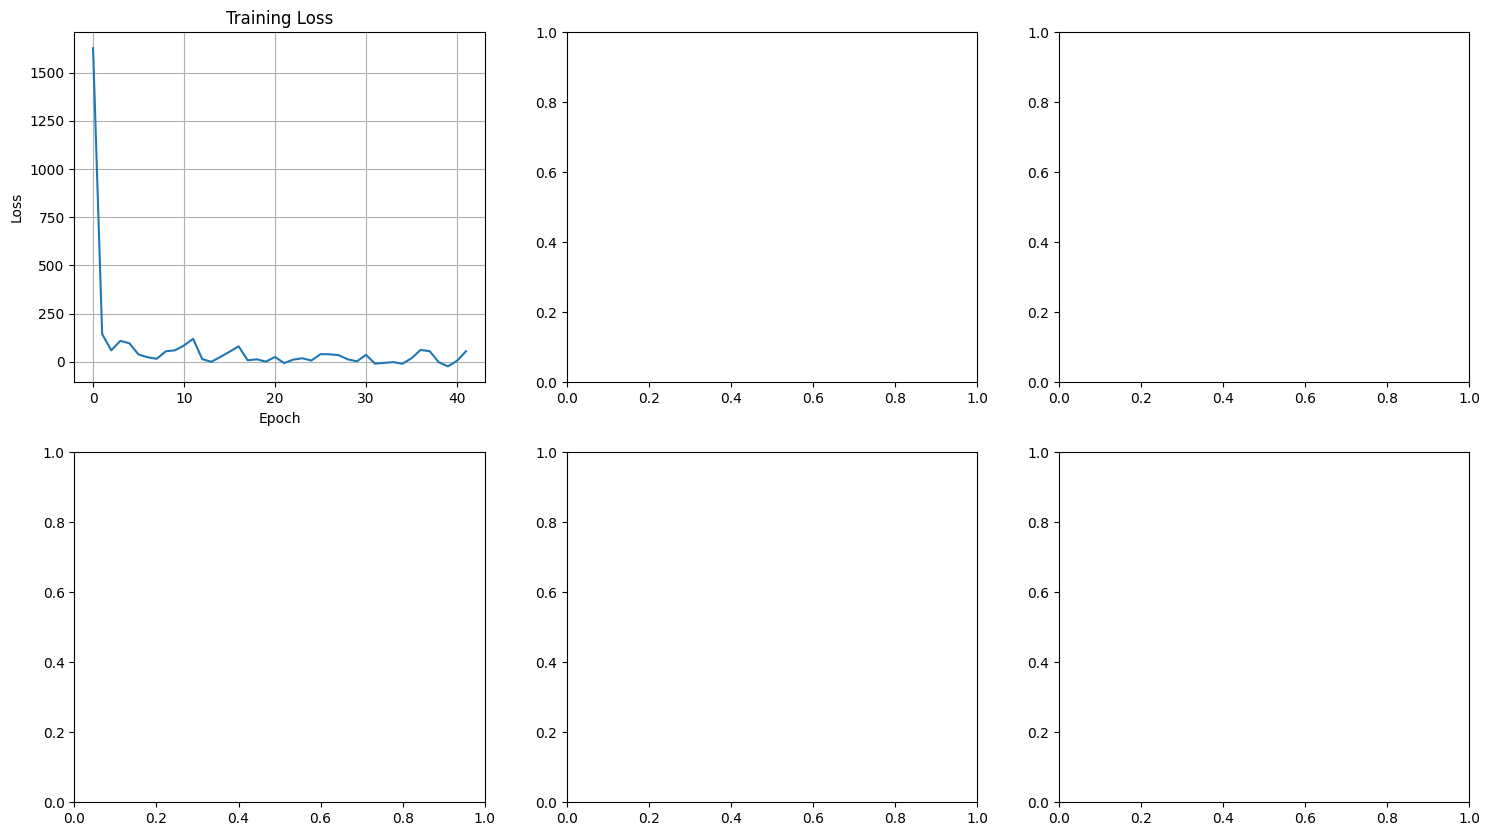

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
if len(history.get('val_loss', [])) > 0:
    val_epochs = [i * CONFIG['validate_every'] for i in range(len(history['val_loss']))]
    axes[0, 0].plot(val_epochs, history['val_loss'], label='Val', marker='o', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Energy gap (E_pos - E_neg)
axes[0, 1].plot(history['train_gap'], label='Train', linewidth=2, color='green')
if len(history.get('val_gap', [])) > 0:
    val_epochs = [i * CONFIG['validate_every'] for i in range(len(history['val_gap']))]
    axes[0, 1].plot(val_epochs, history['val_gap'], label='Val', marker='o', linewidth=2, color='darkgreen')
axes[0, 1].set_title('Energy Gap (E_pos - E_neg)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Gap', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Positive energy
axes[1, 0].plot(history['train_e_pos'], linewidth=2, color='blue')
axes[1, 0].set_title('Positive Sample Energy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('E(u_pos | graph)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Negative energy
axes[1, 1].plot(history['train_e_neg'], linewidth=2, color='red')
axes[1, 1].set_title('Negative Sample Energy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('E(u_neg | graph)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'graph_ebm_training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved to {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_curves.png')}")

## 12. Save Training History

In [ ]:
import json

# Save history as JSON
history_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_training_history.json')

with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to {history_path}")

# Save config
config_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_config.json')
with open(config_path, 'w') as f:
    # Convert non-serializable types
    config_save = {k: str(v) if not isinstance(v, (int, float, str, bool, list, dict, type(None))) else v
                   for k, v in CONFIG.items()}
    json.dump(config_save, f, indent=2)

print(f"✓ Config saved to {config_path}")

# Print summary statistics
print("\n" + "=" * 60)
print("TRAINING STATISTICS")
print("=" * 60)
print(f"Total epochs: {len(history['train_loss'])}")
print(f"Best validation gap: {max(history.get('val_gap', [0])):.4f}")
print(f"Final training loss: {history['train_loss'][-1]:.4f}")
print(f"Final training gap: {history['train_gap'][-1]:.4f}")
print("=" * 60)

✓ Training history saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/training_history.json
✓ Config saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/config.json


## 13. Evaluate Best Model


GRAPH EBM – VALIDATION EVALUATION
✓ Loading BEST checkpoint: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_best.pt


/tmp/ipython-input-1691406943.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)



Evaluating on validation set...


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


EVALUATION RESULTS (GRAPH EBM)
Positive energy (oracle configs):
  mean: -0.7138  |  std: 3.8330
Negative energy (sampler configs):
  mean: 20.7230  |  std: 3.2572

Energy gap (E_pos - E_neg):
  mean: -21.4368  |  std: 1.1167
  Interpretation: if your EBM is well trained, we expect:
    • E_pos < E_neg  ⇒ gap < 0 on average
    • i.e. NEGATIVE mean gap is a GOOD sign

Ranking quality (per graph):
  Fraction of graphs with E_pos < E_neg: 0.998
  (should be >> 0.5 if the energy landscape is informative)

Graph statistics (validation):
  Avg nodes per graph (batch-avg): 38680.7
  Total graphs:                    400
  Total batches:                   4

✓ Evaluation metrics saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_validation_metrics.json


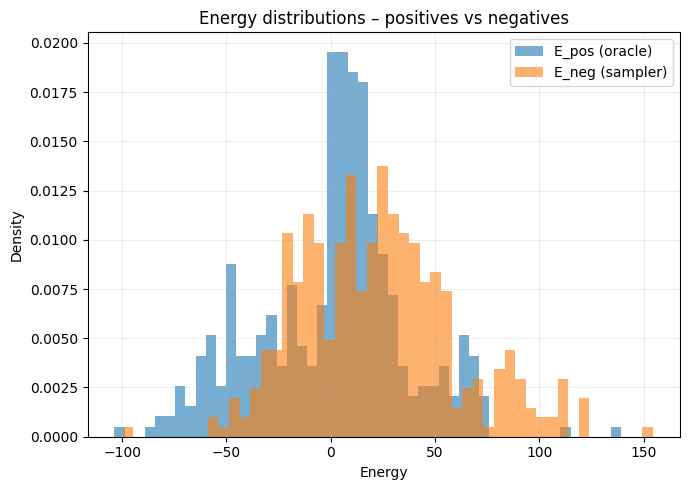

✓ Saved energy histogram to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_energy_hist.png


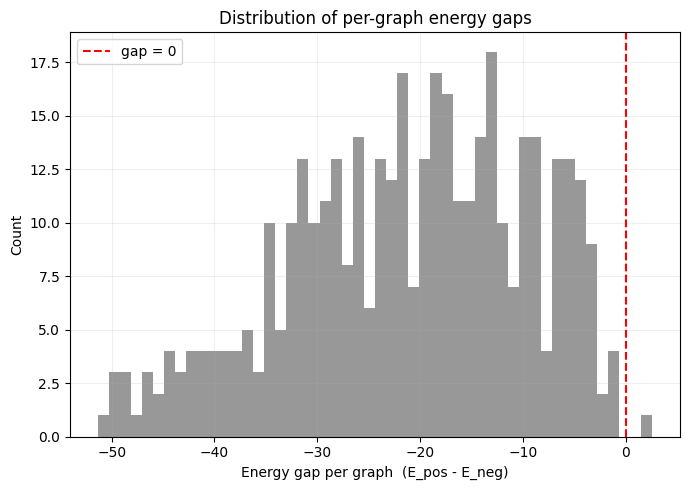

✓ Saved gap histogram to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_gap_hist.png


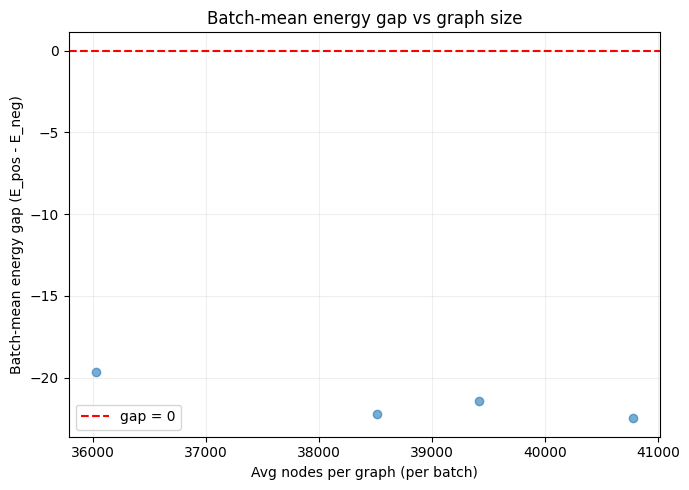

✓ Saved gap vs size scatter to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_gap_vs_size.png

✓ Evaluation & plots completed.


In [10]:
print("\n" + "=" * 60)
print("GRAPH EBM – VALIDATION EVALUATION")
print("=" * 60)

device = CONFIG['device']
output_dir = CONFIG['output_dir']
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------------------------
# 1) Load best (or final) checkpoint
# ------------------------------------------------------------
best_ckpt = os.path.join(output_dir, "graph_ebm_best.pt")
final_ckpt = os.path.join(output_dir, "graph_ebm_final.pt")

ckpt_path = None
if os.path.exists(best_ckpt):
    ckpt_path = best_ckpt
    print(f"✓ Loading BEST checkpoint: {best_ckpt}")
elif os.path.exists(final_ckpt):
    ckpt_path = final_ckpt
    print(f"⚠️  Best checkpoint not found, loading FINAL model: {final_ckpt}")
else:
    print("⚠️  No saved checkpoint found, using current in-memory model")

if ckpt_path is not None:
    state = torch.load(ckpt_path, map_location=device)
    graph_model.load_state_dict(state)

graph_model.to(device)
graph_model.eval()

# ------------------------------------------------------------
# 2) Accumulators for evaluation metrics
# ------------------------------------------------------------

# per-batch means
all_e_pos_mean = []
all_e_neg_mean = []
all_gap_batch = []
all_avg_nodes_batch = []

# per-graph energies
all_e_pos_graph = []
all_e_neg_graph = []
all_gap_graph = []

# per-graph ranking stats
n_graphs_total = 0
n_graphs_pos_lower = 0   # graphs where E_pos < E_neg

print("\nEvaluating on validation set...")
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=False):
        batch = batch.to(device)
        num_graphs = batch.num_graphs

        # --- Positive energies (oracle configurations) ---
        # shape: (num_graphs,)
        e_pos = graph_model(batch).view(-1)

        # --- Negative energies (sampler configurations) ---
        u_neg = graph_sampler.sample(batch)  # same shape as batch.x
        batch_neg = batch.clone()
        batch_neg.x = u_neg
        e_neg = graph_model(batch_neg).view(-1)

        if e_pos.shape != e_neg.shape:
            raise ValueError(f"E_pos shape {e_pos.shape} != E_neg shape {e_neg.shape}")

        # Move to CPU numpy for storage
        e_pos_np = e_pos.detach().cpu().numpy()
        e_neg_np = e_neg.detach().cpu().numpy()
        gap_np = e_pos_np - e_neg_np  # < 0 is good (lower energy for positives)

        # --- per-batch stats ---
        e_pos_mean = float(e_pos_np.mean())
        e_neg_mean = float(e_neg_np.mean())
        gap_batch = float(gap_np.mean())

        all_e_pos_mean.append(e_pos_mean)
        all_e_neg_mean.append(e_neg_mean)
        all_gap_batch.append(gap_batch)

        # --- per-graph stats ---
        all_e_pos_graph.extend(e_pos_np.tolist())
        all_e_neg_graph.extend(e_neg_np.tolist())
        all_gap_graph.extend(gap_np.tolist())

        # ranking: how many graphs have E_pos < E_neg ?
        n_graphs_total += num_graphs
        n_graphs_pos_lower += (e_pos_np < e_neg_np).sum()

        # graph size in this batch
        avg_nodes = batch.x.shape[0] / num_graphs
        all_avg_nodes_batch.append(float(avg_nodes))

# ------------------------------------------------------------
# 3) Aggregate metrics
# ------------------------------------------------------------
all_e_pos_mean = np.array(all_e_pos_mean)
all_e_neg_mean = np.array(all_e_neg_mean)
all_gap_batch = np.array(all_gap_batch)
all_avg_nodes_batch = np.array(all_avg_nodes_batch)

all_e_pos_graph = np.array(all_e_pos_graph)
all_e_neg_graph = np.array(all_e_neg_graph)
all_gap_graph = np.array(all_gap_graph)

energy_pos_mean = float(all_e_pos_mean.mean())
energy_pos_std = float(all_e_pos_mean.std())

energy_neg_mean = float(all_e_neg_mean.mean())
energy_neg_std = float(all_e_neg_mean.std())

energy_gap_mean = float(all_gap_batch.mean())
energy_gap_std = float(all_gap_batch.std())

avg_graph_size = float(all_avg_nodes_batch.mean())
num_batches = len(all_gap_batch)

if n_graphs_total > 0:
    frac_graphs_pos_lower = n_graphs_pos_lower / n_graphs_total
else:
    frac_graphs_pos_lower = float("nan")

# ------------------------------------------------------------
# 4) Print textual summary
# ------------------------------------------------------------
print("\n" + "=" * 60)
print("EVALUATION RESULTS (GRAPH EBM)")
print("=" * 60)
print(f"Positive energy (oracle configs):")
print(f"  mean: {energy_pos_mean:.4f}  |  std: {energy_pos_std:.4f}")
print(f"Negative energy (sampler configs):")
print(f"  mean: {energy_neg_mean:.4f}  |  std: {energy_neg_std:.4f}")
print()
print(f"Energy gap (E_pos - E_neg):")
print(f"  mean: {energy_gap_mean:.4f}  |  std: {energy_gap_std:.4f}")
print("  Interpretation: if your EBM is well trained, we expect:")
print("    • E_pos < E_neg  ⇒ gap < 0 on average")
print("    • i.e. NEGATIVE mean gap is a GOOD sign")
print()
print(f"Ranking quality (per graph):")
print(f"  Fraction of graphs with E_pos < E_neg: {frac_graphs_pos_lower:.3f}")
print("  (should be >> 0.5 if the energy landscape is informative)")
print()
print("Graph statistics (validation):")
print(f"  Avg nodes per graph (batch-avg): {avg_graph_size:.1f}")
print(f"  Total graphs:                    {n_graphs_total}")
print(f"  Total batches:                   {num_batches}")
print("=" * 60)

# ------------------------------------------------------------
# 5) Save evaluation metrics to JSON
# ------------------------------------------------------------
eval_results = {
    "checkpoint_used": ckpt_path if ckpt_path is not None else "in_memory",
    "energy_pos_mean": energy_pos_mean,
    "energy_pos_std": energy_pos_std,
    "energy_neg_mean": energy_neg_mean,
    "energy_neg_std": energy_neg_std,
    "energy_gap_mean": energy_gap_mean,
    "energy_gap_std": energy_gap_std,
    "frac_graphs_pos_lower": frac_graphs_pos_lower,
    "avg_graph_size": avg_graph_size,
    "num_batches": num_batches,
    "num_graphs": int(n_graphs_total),
}

eval_path = os.path.join(output_dir, "graph_ebm_validation_metrics.json")
with open(eval_path, "w") as f:
    json.dump(eval_results, f, indent=2)

print(f"\n✓ Evaluation metrics saved to {eval_path}")

# ------------------------------------------------------------
# 6) Plots – visualize the energy landscape
# ------------------------------------------------------------

# 6.1 Histogram of positive vs negative energies
plt.figure(figsize=(7, 5))
plt.hist(all_e_pos_graph, bins=50, alpha=0.6, label="E_pos (oracle)", density=True)
plt.hist(all_e_neg_graph, bins=50, alpha=0.6, label="E_neg (sampler)", density=True)
plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("Energy distributions – positives vs negatives")
plt.legend()
plt.grid(alpha=0.2)
fig_hist_path = os.path.join(output_dir, "graph_ebm_energy_hist.png")
plt.tight_layout()
plt.savefig(fig_hist_path, dpi=150)
plt.show()
print(f"✓ Saved energy histogram to {fig_hist_path}")

# 6.2 Histogram of per-graph gaps
plt.figure(figsize=(7, 5))
plt.hist(all_gap_graph, bins=50, alpha=0.8, color="tab:gray")
plt.axvline(0.0, color="red", linestyle="--", label="gap = 0")
plt.xlabel("Energy gap per graph  (E_pos - E_neg)")
plt.ylabel("Count")
plt.title("Distribution of per-graph energy gaps")
plt.legend()
plt.grid(alpha=0.2)
fig_gap_hist_path = os.path.join(output_dir, "graph_ebm_gap_hist.png")
plt.tight_layout()
plt.savefig(fig_gap_hist_path, dpi=150)
plt.show()
print(f"✓ Saved gap histogram to {fig_gap_hist_path}")

# 6.3 Scatter: graph size vs batch-mean gap
plt.figure(figsize=(7, 5))
plt.scatter(all_avg_nodes_batch, all_gap_batch, alpha=0.6)
plt.axhline(0.0, color="red", linestyle="--", label="gap = 0")
plt.xlabel("Avg nodes per graph (per batch)")
plt.ylabel("Batch-mean energy gap (E_pos - E_neg)")
plt.title("Batch-mean energy gap vs graph size")
plt.grid(alpha=0.2)
plt.legend()
fig_scatter_path = os.path.join(output_dir, "graph_ebm_gap_vs_size.png")
plt.tight_layout()
plt.savefig(fig_scatter_path, dpi=150)
plt.show()
print(f"✓ Saved gap vs size scatter to {fig_scatter_path}")

print("\n✓ Evaluation & plots completed.")
print("=" * 60)

## 14. Sample and Analyze Configurations

Sampling configurations from Graph EBM...

Test batch size: 128 graphs
Total nodes: 4610592
Nodes per graph (avg): 36020.2

Generating 10 samples...
Ground truth energy: 2.3154

10 samples generated:
Energy range: [21.9256, 21.9659]
Energy mean: 21.9443
Energy std: 0.0119

Sample diversity (avg Hamming): 0.5000


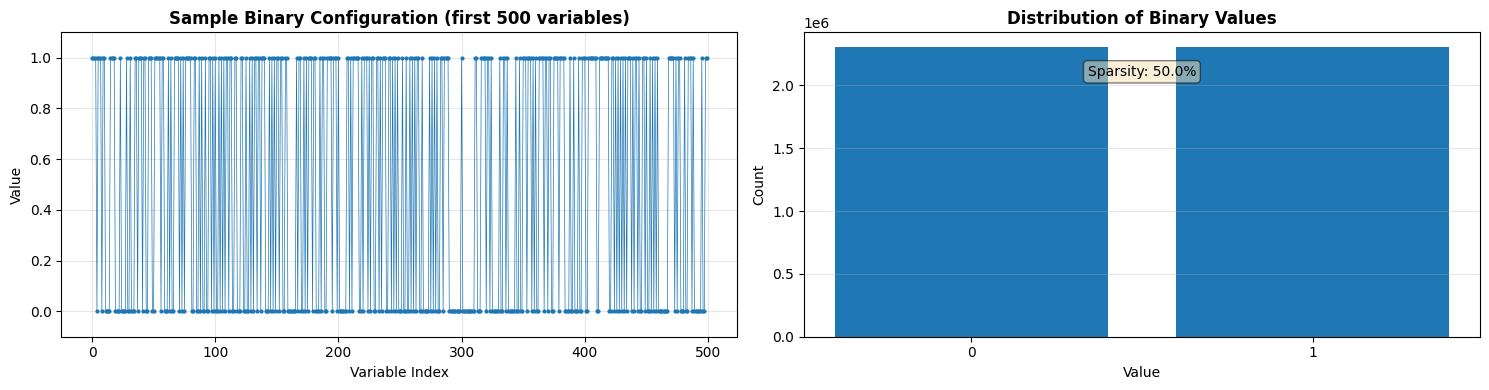


✓ Sample visualization saved

Sample statistics:
  Total variables: 4610592
  Sparsity (% zeros): 50.0%
  Active variables: 2306886


In [11]:
print("Sampling configurations from Graph EBM...\n")

# Get a test graph from validation set
test_batch = next(iter(val_loader)).to(CONFIG['device'])
print(f"Test batch size: {test_batch.h.shape[0]} graphs")
print(f"Total nodes: {test_batch.x.shape[0]}")
print(f"Nodes per graph (avg): {test_batch.x.shape[0] / test_batch.h.shape[0]:.1f}")

# Sample multiple configurations for the same graph
num_samples = 10
print(f"\nGenerating {num_samples} samples...")

sampled_energies = []
sampled_configs = []

with torch.no_grad():
    # Get ground truth energy
    E_true = graph_model(test_batch)
    print(f"Ground truth energy: {E_true.mean().item():.4f}")

    # Sample multiple configurations
    for i in range(num_samples):
        u_sample = graph_sampler.sample(test_batch)
        batch_sample = test_batch.clone()
        batch_sample.x = u_sample
        E_sample = graph_model(batch_sample)

        sampled_energies.append(E_sample.mean().item())
        sampled_configs.append(u_sample.cpu().numpy())

# Analyze samples
print(f"\n{num_samples} samples generated:")
print(f"Energy range: [{min(sampled_energies):.4f}, {max(sampled_energies):.4f}]")
print(f"Energy mean: {np.mean(sampled_energies):.4f}")
print(f"Energy std: {np.std(sampled_energies):.4f}")

# Check diversity (average Hamming distance between samples)
if num_samples > 1:
    hamming_distances = []
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            dist = np.mean(sampled_configs[i] != sampled_configs[j])
            hamming_distances.append(dist)

    avg_diversity = np.mean(hamming_distances)
    print(f"\nSample diversity (avg Hamming): {avg_diversity:.4f}")

# Visualize first sample
sample_u = sampled_configs[0].flatten()
plt.figure(figsize=(15, 4))

# Plot first 500 variables or all if less
n_plot = min(500, len(sample_u))
plt.subplot(1, 2, 1)
plt.plot(sample_u[:n_plot], 'o-', markersize=2, linewidth=0.5)
plt.title(f'Sample Binary Configuration (first {n_plot} variables)', fontsize=12, fontweight='bold')
plt.xlabel('Variable Index')
plt.ylabel('Value')
plt.ylim([-0.1, 1.1])
plt.grid(True, alpha=0.3)

# Plot histogram of values
plt.subplot(1, 2, 2)
unique, counts = np.unique(sample_u, return_counts=True)
plt.bar(unique, counts)
plt.title('Distribution of Binary Values', fontsize=12, fontweight='bold')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Add sparsity info
sparsity = np.mean(sample_u == 0)
plt.text(0.5, max(counts)*0.9, f'Sparsity: {sparsity:.1%}',
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'graph_ebm_sample_configuration.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Sample visualization saved")
print(f"\nSample statistics:")
print(f"  Total variables: {len(sample_u)}")
print(f"  Sparsity (% zeros): {sparsity:.1%}")
print(f"  Active variables: {np.sum(sample_u == 1)}")

## 15. Summary and Next Steps

In [ ]:
# Count model parameters
num_params = sum(p.numel() for p in graph_model.parameters())
num_trainable = sum(p.numel() for p in graph_model.parameters() if p.requires_grad)

# Get dataset info
try:
    dataset_size = len(train_loader.dataset) + len(val_loader.dataset)
except:
    dataset_size = "Unknown"

print("\n" + "=" * 60)
print("GRAPH EBM TRAINING SUMMARY")
print("=" * 60)

print(f"\nModel Architecture:")
print(f"  Model Type: Graph Energy Model (Deep Sets)")
print(f"  Parameters: {num_params:,}")
print(f"  Trainable: {num_trainable:,}")
print(f"  Hidden Dims: {CONFIG['hidden_dims']}")
print(f"  Activation: {CONFIG['activation']}")
print(f"  Dropout: {CONFIG['dropout']}")

print(f"\nTraining Configuration:")
# print(f"  Epochs: {len(history['train_loss'])}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Dataset size: {dataset_size}")
print(f"  Device: {CONFIG['device']}")

# print(f"\nTraining Results:")
# print(f"  Best validation gap: {max(history.get('val_gap', [0])):.4f}")
# print(f"  Final training loss: {history['train_loss'][-1]:.4f}")
# print(f"  Final training gap: {history['train_gap'][-1]:.4f}")
# print(f"  Final E_pos: {history['train_e_pos'][-1]:.4f}")
# print(f"  Final E_neg: {history['train_e_neg'][-1]:.4f}")

if 'energy_gap_mean' in eval_results:
    print(f"\nEvaluation Metrics:")
    print(f"  Energy gap (mean): {eval_results['energy_gap_mean']:.4f} ± {eval_results['energy_gap_std']:.4f}")
    print(f"  Avg graph size: {eval_results['avg_graph_size']:.1f} nodes")

print(f"\nSaved Artifacts:")
print(f"  Best model: {os.path.join(CONFIG['output_dir'], 'graph_ebm_best.pt')}")
print(f"  Final model: {os.path.join(CONFIG['output_dir'], 'graph_ebm_final.pt')}")
print(f"  Training history: {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_history.json')}")
print(f"  Evaluation results: {os.path.join(CONFIG['output_dir'], 'graph_ebm_evaluation_results.json')}")
print(f"  Training curves: {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_curves.png')}")
print(f"  Sample visualization: {os.path.join(CONFIG['output_dir'], 'graph_ebm_sample_configuration.png')}")

print(f"\nNext Steps:")
print(f"  1. Analyze training curves and energy gaps")
print(f"  2. Test on different graph sizes and scenarios")
print(f"  3. Compare with flat EBM baseline")
print(f"  4. Tune sampling strategy (exact vs approximate)")
print(f"  5. Use sampled configurations for MILP warmstart")
print(f"  6. Evaluate on unseen scenarios")

print("\n" + "=" * 60)
print("✓ GRAPH EBM TRAINING COMPLETE!")
print("=" * 60)

# Optional: Show model summary
print(f"\nModel Summary:")
print(graph_model)


GRAPH EBM TRAINING SUMMARY

Model Architecture:
  Model Type: Graph Energy Model (Deep Sets)
  Parameters: 115,585
  Trainable: 115,585
  Hidden Dims: [256, 256, 64]
  Activation: gelu
  Dropout: 0.1

Training Configuration:
  Batch size: 128
  Learning rate: 0.0001
  Dataset size: 2000
  Device: cuda

Evaluation Metrics:
  Energy gap (mean): -21.4566 ± 1.1141
  Avg graph size: 38680.7 nodes

Saved Artifacts:
  Best model: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_best.pt
  Final model: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_final.pt
  Training history: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_training_history.json
  Evaluation results: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_evaluation_results.json
  Training curves: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_training_curves.png
  Sample visualization: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_sample_configurat

## 16. Langevin Sampler Evaluation

This section implements and evaluates a Langevin discretized sampler for binary variables, working with continuous logits and sigmoid relaxation.

In [12]:
import torch
from copy import deepcopy

class LangevinBinarySampler:
    """
    Langevin sampler for binary decision variables encoded in batch.x.

    - Works with relaxed logits z (R^d), decisions u = sigmoid(z) in (0,1).
    - Uses gradient of E(batch_with_u) w.r.t. z.
    - Annealed temperature schedule.
    - Returns a binary tensor u_bin with the same shape as batch.x (or masked dims).
    """

    def __init__(
        self,
        model,
        decision_mask=None,        # bool vector of shape (F,) over feature dim, or None for all features
        num_steps=30,
        step_size=1e-2,
        noise_scale=1.0,
        temp_min=0.1,
        temp_max=1.0,
        init_mode="bernoulli",     # "bernoulli" or "oracle"
        init_p=0.5,                # Bernoulli(p) if init_mode=="bernoulli"
        device=None,
    ):
        self.model = model
        self.decision_mask = decision_mask  # torch.BoolTensor [F] or None
        self.num_steps = num_steps
        self.step_size = step_size
        self.noise_scale = noise_scale
        self.temp_min = temp_min
        self.temp_max = temp_max
        self.init_mode = init_mode
        self.init_p = init_p
        self.device = device

    def _extract_decisions(self, x):
        """
        x: [N_nodes, F]
        returns decisions view [N_nodes, D_dec], mask_used
        """
        if self.decision_mask is None:
            # all features are decisions
            return x, None
        else:
            return x[:, self.decision_mask], self.decision_mask

    def _inject_decisions(self, x, u, mask):
        """
        Put decisions u back into x (in-place clone).
        x: [N_nodes, F], u: [N_nodes, D_dec]
        mask: bool [F] or None
        """
        x_new = x.clone()
        if mask is None:
            x_new = u
        else:
            x_new[:, mask] = u
        return x_new

    def _init_logits(self, x_dec):
        """
        x_dec: [N_nodes, D_dec], initial decisions (oracle or anything).
        Returns logits z0: [N_nodes, D_dec]
        """
        if self.init_mode == "oracle":
            # Use oracle decisions (0/1) -> logit in (-inf, +inf) clipped
            eps = 1e-4
            u0 = x_dec.clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
        elif self.init_mode == "bernoulli":
            # Pure Bernoulli(p) init
            u0 = torch.bernoulli(torch.full_like(x_dec, self.init_p))
            eps = 1e-4
            u0 = u0.clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
        else:
            raise ValueError(f"Unknown init_mode: {self.init_mode}")
        return z0

    def sample(self, batch):
        """
        Main entry point: returns u_bin with same shape as batch.x.

        IMPORTANT: ne pas appeler cette méthode sous torch.no_grad(),
        car on a besoin des gradients par rapport à z.
        """

        device = self.device or batch.x.device

        # On clone le batch pour ne pas l'écraser
        batch = deepcopy(batch)
        batch = batch.to(device)

        # 1) Extraire les dimensions décisionnelles
        x = batch.x  # [N_nodes, F]
        x_dec, mask = self._extract_decisions(x)  # [N_nodes, D_dec]

        # 2) Initialiser les logits z
        z = self._init_logits(x_dec).to(device)
        z.requires_grad_(True)

        # 3) Boucle de Langevin
        for k in range(self.num_steps):
            # Température annealed (linéaire)
            if self.num_steps > 1:
                t = k / (self.num_steps - 1)
            else:
                t = 0.0
            T_k = self.temp_max + t * (self.temp_min - self.temp_max)  # from max -> min

            # Relaxation binaire
            u = torch.sigmoid(z)  # (0,1)

            # Injecter dans le batch
            x_new = self._inject_decisions(x, u, mask)
            batch.x = x_new

            # Calculer l'énergie moyenne sur le batch (scalaire)
            # On force enable_grad pour E même en contexte global no_grad
            with torch.enable_grad():
                E = self.model(batch).mean()

            # Gradient de E par rapport à z
            grad_z = torch.autograd.grad(E, z, create_graph=False, retain_graph=False)[0]

            # Bruit gaussien
            noise = torch.randn_like(z)

            # Mise à jour des logits (Langevin discretisé)
            step = self.step_size
            z = z - step * grad_z + (self.noise_scale * T_k * (step ** 0.5)) * noise

            # Préparer pour itération suivante
            z = z.detach()
            z.requires_grad_(True)

        # 4) Dernière relaxation + threshold
        u_final = torch.sigmoid(z)
        u_bin = (u_final > 0.5).float()

        # 5) Reconstruire un tensor [N_nodes, F] comme dans batch.x
        x_sampled = self._inject_decisions(x, u_bin, mask)

        return x_sampled

print("✓ LangevinBinarySampler class defined")

✓ LangevinBinarySampler class defined


In [13]:
class ImprovedLangevinSampler(LangevinBinarySampler):
    def _init_logits(self, x_dec):
        if self.init_mode == "soft":
            # Initialize near 0 (prob ~ 0.5) with small noise
            # This places us in the high-gradient region of the sigmoid
            return torch.randn_like(x_dec) * 0.1
        else:
            return super()._init_logits(x_dec)

print("\u2713 ImprovedLangevinSampler defined with 'soft' initialization support")

✓ ImprovedLangevinSampler defined with 'soft' initialization support


In [14]:
class NormalizedLangevinSampler(ImprovedLangevinSampler):
    def sample(self, batch):
        # Same initialization as before
        device = self.device or batch.x.device
        batch = deepcopy(batch).to(device)
        x_dec, mask = self._extract_decisions(batch.x)
        z = self._init_logits(x_dec).to(device).requires_grad_(True)

        print(f"Sampling with Normalized Gradients (Steps={self.num_steps})...")

        for k in range(self.num_steps):
            # Annealing
            t = k / (self.num_steps - 1) if self.num_steps > 1 else 0
            T_k = self.temp_max + t * (self.temp_min - self.temp_max)

            # Forward
            u = torch.sigmoid(z)
            batch.x = self._inject_decisions(batch.x, u, mask)
            with torch.enable_grad():
                E = self.model(batch).mean()

            # Backward
            grad_z = torch.autograd.grad(E, z)[0]

            # --- GRADIENT NORMALIZATION ---
            # Scale gradient to have std=1.0
            g_std = grad_z.std()
            if g_std > 1e-9:
                grad_z = grad_z / g_std
            # ------------------------------

            # Langevin Update
            noise = torch.randn_like(z)
            # We also scale noise step slightly differently to match normalized grad dynamics
            # Update: z = z - step * grad + noise_term
            step = self.step_size

            # Note: With normalized gradients, the step_size has a direct interpretation
            # as "logit shift magnitude".
            z = z - step * grad_z + (self.noise_scale * T_k * np.sqrt(step)) * noise

            z = z.detach().requires_grad_(True)

        # Finalize
        u_bin = (z > 0).float()
        return self._inject_decisions(batch.x, u_bin, mask)

print("\u2713 NormalizedLangevinSampler defined")

✓ NormalizedLangevinSampler defined


In [15]:
print("\n" + "=" * 60)
print("GRAPH EBM – VALIDATION EVALUATION")
print("=" * 60)

device = CONFIG['device']
output_dir = CONFIG['output_dir']
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------------------------
# 1) Load best (or final) checkpoint
# ------------------------------------------------------------
best_ckpt = os.path.join(output_dir, "graph_ebm_best.pt")
final_ckpt = os.path.join(output_dir, "graph_ebm_final.pt")

ckpt_path = None
if os.path.exists(best_ckpt):
    ckpt_path = best_ckpt
    print(f"✓ Loading BEST checkpoint: {best_ckpt}")
elif os.path.exists(final_ckpt):
    ckpt_path = final_ckpt
    print(f"⚠️  Best checkpoint not found, loading FINAL model: {final_ckpt}")
else:
    print("⚠️  No saved checkpoint found, using current in-memory model")

if ckpt_path is not None:
    state = torch.load(ckpt_path, map_location=device)
    graph_model.load_state_dict(state)

graph_model.to(device)
graph_model.eval()

# Run Evaluation with Normalized Sampler
normalized_sampler = NormalizedLangevinSampler(
    model=graph_model,
    num_steps=100,
    step_size=0.5,      # Aggressive step size (move 0.5 sigmas per step)
    noise_scale=0.2,    # Lower noise to focus on gradient descent
    temp_min=0.1,
    temp_max=1.0,
    init_mode="soft",
    device=CONFIG['device']
)

print("Running evaluation...")
test_batch = test_batch.to(CONFIG['device'])

# Sample
u_norm = normalized_sampler.sample(test_batch)

# Metrics
b_norm = test_batch.clone()
b_norm.x = u_norm

with torch.no_grad():
    E_oracle = graph_model(test_batch).mean().item()
    E_found = graph_model(b_norm).mean().item()

hamming = (test_batch.x != u_norm).float().mean().item()

print("="*40)
print(f"E_oracle: {E_oracle:.4f}")
print(f"E_found:  {E_found:.4f}")
print(f"Gap:      {E_found - E_oracle:.4f}")
print(f"Hamming:  {hamming:.2%}")

if hamming < 0.45:
    print("\u2713 Success! The sampler has broken away from random (50%) and found a structure.")
else:
    print("\u26a0\ufe0f Still close to random. Step size might be too large or small.")


GRAPH EBM – VALIDATION EVALUATION
✓ Loading BEST checkpoint: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_best.pt
Running evaluation...
Sampling with Normalized Gradients (Steps=100)...


/tmp/ipython-input-486588035.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


E_oracle: 2.3154
E_found:  -3.2180
Gap:      -5.5334
Hamming:  10.79%
✓ Success! The sampler has broken away from random (50%) and found a structure.


In [16]:
# Extended evaluation on validation set
print("Running extended Langevin evaluation on validation set...")
print("=" * 60)

graph_model.eval()
results = {
    'e_true': [],
    'e_sample': [],
    'hamming_dist': [],
    'energy_improvement': []
}

# Evaluate on first few validation batches
num_eval_batches = min(3, len(val_loader))
for i, batch in enumerate(val_loader):
    if i >= num_eval_batches:
        break

    batch = batch.to(CONFIG['device'])

    # Sample with Langevin
    u_sample = normalized_sampler.sample(batch)
    batch_sample = batch.clone()
    batch_sample.x = u_sample

    # Compute energies
    with torch.no_grad():
        e_true = graph_model(batch).mean().item()
        e_sample = graph_model(batch_sample).mean().item()

    # Compute metrics
    hamming = (batch.x != batch_sample.x).float().mean().item()
    improvement = e_true - e_sample

    results['e_true'].append(e_true)
    results['e_sample'].append(e_sample)
    results['hamming_dist'].append(hamming)
    results['energy_improvement'].append(improvement)

    print(f"Batch {i+1}/{num_eval_batches}: E_oracle={e_true:.4f}, "
          f"E_sample={e_sample:.4f}, Hamming={hamming:.4f}, "
          f"Improvement={improvement:.4f}")

# Aggregate statistics
print("\n" + "=" * 60)
print("AGGREGATE STATISTICS")
print("=" * 60)
print(f"Average E_oracle:        {np.mean(results['e_true']):.4f} ± {np.std(results['e_true']):.4f}")
print(f"Average E_sample:        {np.mean(results['e_sample']):.4f} ± {np.std(results['e_sample']):.4f}")
print(f"Average Hamming distance: {np.mean(results['hamming_dist']):.4f} ± {np.std(results['hamming_dist']):.4f}")
print(f"Average energy improvement: {np.mean(results['energy_improvement']):.4f} ± {np.std(results['energy_improvement']):.4f}")

if np.mean(results['energy_improvement']) > 0:
    print("\n✓ On average, Langevin sampler finds BETTER configurations than oracle!")
else:
    print("\n⚠ Langevin sampler did not improve over oracle on average")

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING SUGGESTIONS")
print("=" * 60)
print("If results are not satisfactory, try adjusting:")
print("  1. num_steps: increase for more exploration (20-50)")
print("  2. step_size: decrease if diverging (1e-3 to 5e-3), increase if stuck (2e-2 to 5e-2)")
print("  3. noise_scale: increase for more exploration (0.8-1.2), decrease for exploitation (0.2-0.5)")
print("  4. temp_min/temp_max: adjust annealing schedule")
print("  5. init_mode: try 'oracle' to verify sampler doesn't destroy good solutions")
print("=" * 60)

Running extended Langevin evaluation on validation set...
Sampling with Normalized Gradients (Steps=100)...
Batch 1/3: E_oracle=2.3154, E_sample=-3.2180, Hamming=0.1079, Improvement=5.5334
Sampling with Normalized Gradients (Steps=100)...
Batch 2/3: E_oracle=0.5768, E_sample=-5.5793, Hamming=0.1109, Improvement=6.1561
Sampling with Normalized Gradients (Steps=100)...
Batch 3/3: E_oracle=1.5193, E_sample=-4.9073, Hamming=0.1204, Improvement=6.4266

AGGREGATE STATISTICS
Average E_oracle:        1.4705 ± 0.7106
Average E_sample:        -4.5682 ± 0.9933
Average Hamming distance: 0.1131 ± 0.0053
Average energy improvement: 6.0387 ± 0.3740

✓ On average, Langevin sampler finds BETTER configurations than oracle!

HYPERPARAMETER TUNING SUGGESTIONS
If results are not satisfactory, try adjusting:
  1. num_steps: increase for more exploration (20-50)
  2. step_size: decrease if diverging (1e-3 to 5e-3), increase if stuck (2e-2 to 5e-2)
  3. noise_scale: increase for more exploration (0.8-1.2), de

## 17. LP Worker Plugin: Multi-Candidate Generation & MILP Validation

This section tests whether the EBM+Langevin sampler is a **real accelerator** or a **brilliant energetic hallucinogen**.

### Workflow:
1. **Multi-candidate generation**: Generate K candidates per graph with different seeds
2. **Energy & Hamming analysis**: Analyze energy distribution and distance from oracle
3. **LP Worker validation**: Solve LP dispatch for sampled commitments
4. **Cost comparison**: Compare MILP oracle cost vs. Langevin candidates

In [17]:
# Import MILP solver utilities
from src.milp.solve import solve_scenario
from src.milp.model import build_uc_model
from src.milp.scenario_loader import load_scenario_data
from pyomo.environ import value
from pathlib import Path

print("✓ MILP solver utilities imported")

✓ MILP solver utilities imported


In [18]:
def generate_k_candidates(sampler, batch, k=10, different_seeds=True):
    """
    Generate K candidate solutions using the Langevin sampler.

    Args:
        sampler: LangevinBinarySampler instance
        batch: PyG batch object
        k: Number of candidates to generate
        different_seeds: Whether to use different random seeds for each candidate

    Returns:
        candidates: List of K tensors, each with sampled binary variables
        energies: List of K energy values
    """
    candidates = []
    energies = []

    graph_model.eval()

    for i in range(k):
        # Set different seed for each candidate
        if different_seeds:
            torch.manual_seed(CONFIG['seed'] + i * 1000)

        # Generate candidate
        u_candidate = sampler.sample(batch)

        # Create batch with candidate
        batch_candidate = batch.clone()
        batch_candidate.x = u_candidate

        # Compute energy
        with torch.no_grad():
            E = graph_model(batch_candidate).mean().item()

        candidates.append(u_candidate.cpu())
        energies.append(E)

    return candidates, energies

print("✓ Multi-candidate generation function defined")

✓ Multi-candidate generation function defined


In [19]:
def extract_binary_commitments(u_flat, timesteps=96):
    """
    Extract binary commitments from flattened binary vector.

    Args:
        u_flat: Flattened binary vector [N_total_bins]
        timesteps: Number of timesteps (default: 96)

    Returns:
        commitments: Dict with thermal/nuclear/battery/pumped commitments
    """
    # Assuming structure: [thermal, nuclear, battery_on, pumped_on] per zone per timestep
    # Based on dataset structure: 9600 binaries for 96 timesteps = 100 binaries per timestep
    # This needs to match your actual data structure

    u_np = u_flat.cpu().numpy().flatten()
    n_bins_per_t = len(u_np) // timesteps

    commitments = {
        'thermal': [],
        'nuclear': [],
        'battery_on': [],
        'pumped_on': []
    }

    # Parse based on your actual structure
    # This is a placeholder - adjust based on your scenario structure
    for t in range(timesteps):
        start_idx = t * n_bins_per_t
        # Assuming first 25% thermal, next 25% nuclear, next 25% battery, last 25% pumped
        quarter = n_bins_per_t // 4

        commitments['thermal'].append(u_np[start_idx:start_idx+quarter])
        commitments['nuclear'].append(u_np[start_idx+quarter:start_idx+2*quarter])
        commitments['battery_on'].append(u_np[start_idx+2*quarter:start_idx+3*quarter])
        commitments['pumped_on'].append(u_np[start_idx+3*quarter:start_idx+4*quarter])

    return commitments

print("✓ Binary commitment extraction function defined")

✓ Binary commitment extraction function defined


In [25]:
def solve_lp_with_commitment(scenario_path, u_binary=None, binary_dict=None):
    """
    Solve LP dispatch with fixed binary commitments.

    Args:
        scenario_path: Path to scenario file
        u_binary: Flattened binary vector [N_bins] (for Langevin candidates)
        binary_dict: Dict with structured binaries (for true oracle)
                    Format: {
                        "u_thermal": {"zone": [0,1,1,...]},
                        "u_nuclear": {"zone": [1,1,1,...]},
                        ...
                    }

    Returns:
        result: Dict with objective, solve time, feasibility status
    """
    import warnings
    import logging
    from pyomo.environ import SolverFactory, value
    from pyomo.core import TransformationFactory

    # Suppress Pyomo warnings
    pyomo_logger = logging.getLogger('pyomo')
    old_level = pyomo_logger.level
    pyomo_logger.setLevel(logging.ERROR)  # Only show errors, not warnings

    # Also suppress Python warnings from Pyomo
    warnings.filterwarnings('ignore', category=Warning, module='pyomo.*')

    try:
        # Load scenario data
        data = load_scenario_data(Path(scenario_path))

        # Build model with binaries
        model = build_uc_model(data, enable_duals=False)

        # Fix binary variables based on input type
        fixed_count = 0

        if binary_dict is not None:
            # Use structured binaries (TRUE oracle from JSON)
            print(f"    Fixing binaries from structured dict...")

            for zone in model.Z:
                zone_str = str(zone)
                for t in model.T:
                    t_int = int(t)

                    # Fix thermal commitment
                    if zone_str in binary_dict.get("u_thermal", {}):
                        val = binary_dict["u_thermal"][zone_str][t_int]
                        model.u_thermal[zone, t].fix(float(val))
                        fixed_count += 1

                    # Fix thermal startup
                    if zone_str in binary_dict.get("v_thermal_startup", {}):
                        val = binary_dict["v_thermal_startup"][zone_str][t_int]
                        model.v_thermal_startup[zone, t].fix(float(val))
                        fixed_count += 1

                    # Fix nuclear commitment
                    if zone_str in binary_dict.get("u_nuclear", {}):
                        val = binary_dict["u_nuclear"][zone_str][t_int]
                        model.u_nuclear[zone, t].fix(float(val))
                        fixed_count += 1

                    # Fix nuclear startup
                    if zone_str in binary_dict.get("v_nuclear_startup", {}):
                        val = binary_dict["v_nuclear_startup"][zone_str][t_int]
                        model.v_nuclear_startup[zone, t].fix(float(val))
                        fixed_count += 1

            print(f"    Fixed {fixed_count} binary variables from structured dict")

        elif u_binary is not None:
            # Use flattened binary vector (Langevin candidates)
            # This assumes the dataset structure
            print(f"    Fixing binaries from flattened vector...")

            u_np = u_binary.cpu().numpy().flatten() if hasattr(u_binary, 'cpu') else u_binary.flatten()

            n_zones = len(data.zones)
            n_timesteps = len(data.periods)

            # Try to infer structure - assume 4 binaries per zone per timestep
            # [u_thermal, v_thermal_startup, u_nuclear, v_nuclear_startup]
            expected_size = n_zones * n_timesteps * 4

            if len(u_np) == expected_size:
                # Standard structure
                idx = 0
                for t in range(n_timesteps):
                    for z_idx, zone in enumerate(data.zones):
                        if idx + 3 < len(u_np):
                            model.u_thermal[zone, t].fix(float(u_np[idx]))
                            model.v_thermal_startup[zone, t].fix(float(u_np[idx + 1]))
                            model.u_nuclear[zone, t].fix(float(u_np[idx + 2]))
                            model.v_nuclear_startup[zone, t].fix(float(u_np[idx + 3]))
                            idx += 4
                            fixed_count += 4
            else:
                # Try alternative: maybe it's just the binary values, no structure
                # Assume first half is thermal, second half is nuclear
                print(f"    ⚠ Size mismatch: got {len(u_np)}, expected {expected_size}")
                print(f"    Attempting best-effort mapping...")

                # Just fix what we can
                n_bins_per_type = len(u_np) // 2
                for t in range(min(n_timesteps, len(u_np) // n_zones)):
                    for z_idx, zone in enumerate(data.zones):
                        idx = t * n_zones + z_idx
                        if idx < n_bins_per_type:
                            # First half: thermal-related
                            model.u_thermal[zone, t].fix(float(u_np[idx]))
                            fixed_count += 1
                        if idx + n_bins_per_type < len(u_np):
                            # Second half: nuclear-related
                            model.u_nuclear[zone, t].fix(float(u_np[idx + n_bins_per_type]))
                            fixed_count += 1

            print(f"    Fixed {fixed_count} binary variables from flattened vector")

        # Relax any remaining integer variables
        TransformationFactory("core.relax_integer_vars").apply_to(model)

        # Solve as LP
        solver = SolverFactory("highs")
        import time
        start = time.time()

        # Important: allow loading of non-optimal solutions
        results = solver.solve(model, tee=False, load_solutions=False)
        solve_time = time.time() - start

        # Check status before loading solution
        termination = results.solver.termination_condition
        status = results.solver.status

        feasible = False
        objective = float('inf')

        if termination in ['optimal', 'feasible']:
            model.solutions.load_from(results)
            objective = value(model.obj)
            feasible = True
        elif termination == 'infeasible':
            objective = float('inf')
            feasible = False
        else:
            # Try to load anyway
            try:
                model.solutions.load_from(results)
                objective = value(model.obj)
                feasible = True
            except:
                objective = float('inf')
                feasible = False

        return {
            'objective': objective,
            'solve_time': solve_time,
            'status': str(status),
            'termination': str(termination),
            'feasible': feasible,
            'fixed_count': fixed_count,
        }

    except Exception as e:
        import traceback
        print(f"    Error details: {traceback.format_exc()}")
        return {
            'objective': float('inf'),
            'solve_time': 0.0,
            'status': 'error',
            'termination': str(e),
            'feasible': False,
            'fixed_count': 0,
        }

print("✓ LP solver with commitment function defined (supports both dict and vector)")

✓ LP solver with commitment function defined (supports both dict and vector)


In [21]:
# Configuration for multi-candidate evaluation
K_CANDIDATES = 10  # Number of candidates to generate per graph
N_GRAPHS_TO_EVAL = 5  # Number of graphs to fully evaluate with LP

print("=" * 80)
print("MULTI-CANDIDATE GENERATION & EVALUATION")
print("=" * 80)
print(f"Configuration:")
print(f"  - K candidates per graph: {K_CANDIDATES}")
print(f"  - Graphs for full LP evaluation: {N_GRAPHS_TO_EVAL}")
print(f"  - Langevin sampler steps: {normalized_sampler.num_steps}")  # <--- FIXED
print("=" * 80)

# Select a subset of validation graphs
val_batch = next(iter(val_loader)).to(CONFIG['device'])

# We'll analyze the first N_GRAPHS_TO_EVAL graphs from the batch
# Extract individual graphs from the batch
individual_graphs = []
scenario_ids = []

for i in range(min(N_GRAPHS_TO_EVAL, val_batch.num_graphs)):
    # Get mask for this graph
    mask = (val_batch.batch == i)

    # Extract graph data
    graph_data = Data(
        x=val_batch.x[mask],
        h=val_batch.h[i:i+1],
        batch=torch.zeros(mask.sum(), dtype=torch.long, device=CONFIG['device'])
    )

    # Try to get scenario_id if available
    if hasattr(val_batch, 'scenario_id'):
        if isinstance(val_batch.scenario_id, list):
            scenario_id = val_batch.scenario_id[i] if i < len(val_batch.scenario_id) else f"graph_{i}"
        else:
            scenario_id = f"graph_{i}"
    else:
        scenario_id = f"graph_{i}"

    individual_graphs.append(graph_data)
    scenario_ids.append(scenario_id)

print(f"\n✓ Extracted {len(individual_graphs)} individual graphs for analysis")
print(f"  Scenario IDs: {scenario_ids}")

MULTI-CANDIDATE GENERATION & EVALUATION
Configuration:
  - K candidates per graph: 10
  - Graphs for full LP evaluation: 5
  - Langevin sampler steps: 100

✓ Extracted 5 individual graphs for analysis
  Scenario IDs: ['scenario_00990', 'scenario_01627', 'scenario_01998', 'scenario_01058', 'scenario_01888']


In [22]:
# Generate K candidates for each graph
print("\n" + "=" * 80)
print("GENERATING CANDIDATES")
print("=" * 80)

all_results = []

for graph_idx, (graph, scenario_id) in enumerate(zip(individual_graphs, scenario_ids)):
    print(f"\n[Graph {graph_idx+1}/{len(individual_graphs)}] {scenario_id}")
    print("-" * 80)

    # Get oracle (true) configuration
    graph_oracle = graph.clone().to(CONFIG['device'])
    with torch.no_grad():
        E_oracle = graph_model(graph_oracle).mean().item()

    print(f"Oracle energy: {E_oracle:.4f}")

    # Generate K candidates
    print(f"Generating {K_CANDIDATES} candidates...")
    candidates, energies = generate_k_candidates(
        normalized_sampler,  # <--- FIXED: Use the working sampler
        graph,
        k=K_CANDIDATES,
        different_seeds=True
    )

    # Compute Hamming distances from oracle
    hamming_dists = []
    for candidate in candidates:
        hamming = (graph.x.cpu() != candidate).float().mean().item()
        hamming_dists.append(hamming)

    # Store results
    result = {
        'scenario_id': scenario_id,
        'graph_idx': graph_idx,
        'E_oracle': E_oracle,
        'candidates': candidates,
        'energies': energies,
        'hamming_dists': hamming_dists,
        'best_candidate_idx': np.argmin(energies),
        'worst_candidate_idx': np.argmax(energies),
    }
    all_results.append(result)

    # Print statistics
    print(f"  Candidate energies: min={min(energies):.4f}, "
          f"max={max(energies):.4f}, mean={np.mean(energies):.4f} ± {np.std(energies):.4f}")
    print(f"  Hamming distances: min={min(hamming_dists):.4f}, "
          f"max={max(hamming_dists):.4f}, mean={np.mean(hamming_dists):.4f}")
    print(f"  Best candidate: idx={result['best_candidate_idx']}, "
          f"E={energies[result['best_candidate_idx']]:.4f}, "
          f"Hamming={hamming_dists[result['best_candidate_idx']]:.4f}")

    # Check if best candidate is better than oracle
    if min(energies) < E_oracle:
        print(f"  ✓ Found candidate with LOWER energy than oracle! Δ={E_oracle - min(energies):.4f}")
    else:
        print(f"  ⚠ All candidates have higher energy than oracle. Gap={min(energies) - E_oracle:.4f}")

print("\n" + "=" * 80)
print("✓ Candidate generation complete!")
print("=" * 80)


GENERATING CANDIDATES

[Graph 1/5] scenario_00990
--------------------------------------------------------------------------------
Oracle energy: 34.4246
Generating 10 candidates...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
  Candidate energies: min=24.1820, max=24.1820, mean=24.1820 ± 0.0000
  Hamming distances: min=0.1053, max=0.1053, mean=0.1053
  Best candidate: idx=0, E=24.1820, Hamming=0.1053
  ✓ Found candidate with LOWER energy than oracle! Δ=10.2426

[Graph 2/5] scenario_01627
--------------------------------------------------


VISUALIZATION: ENERGY & HAMMING DISTRIBUTIONS


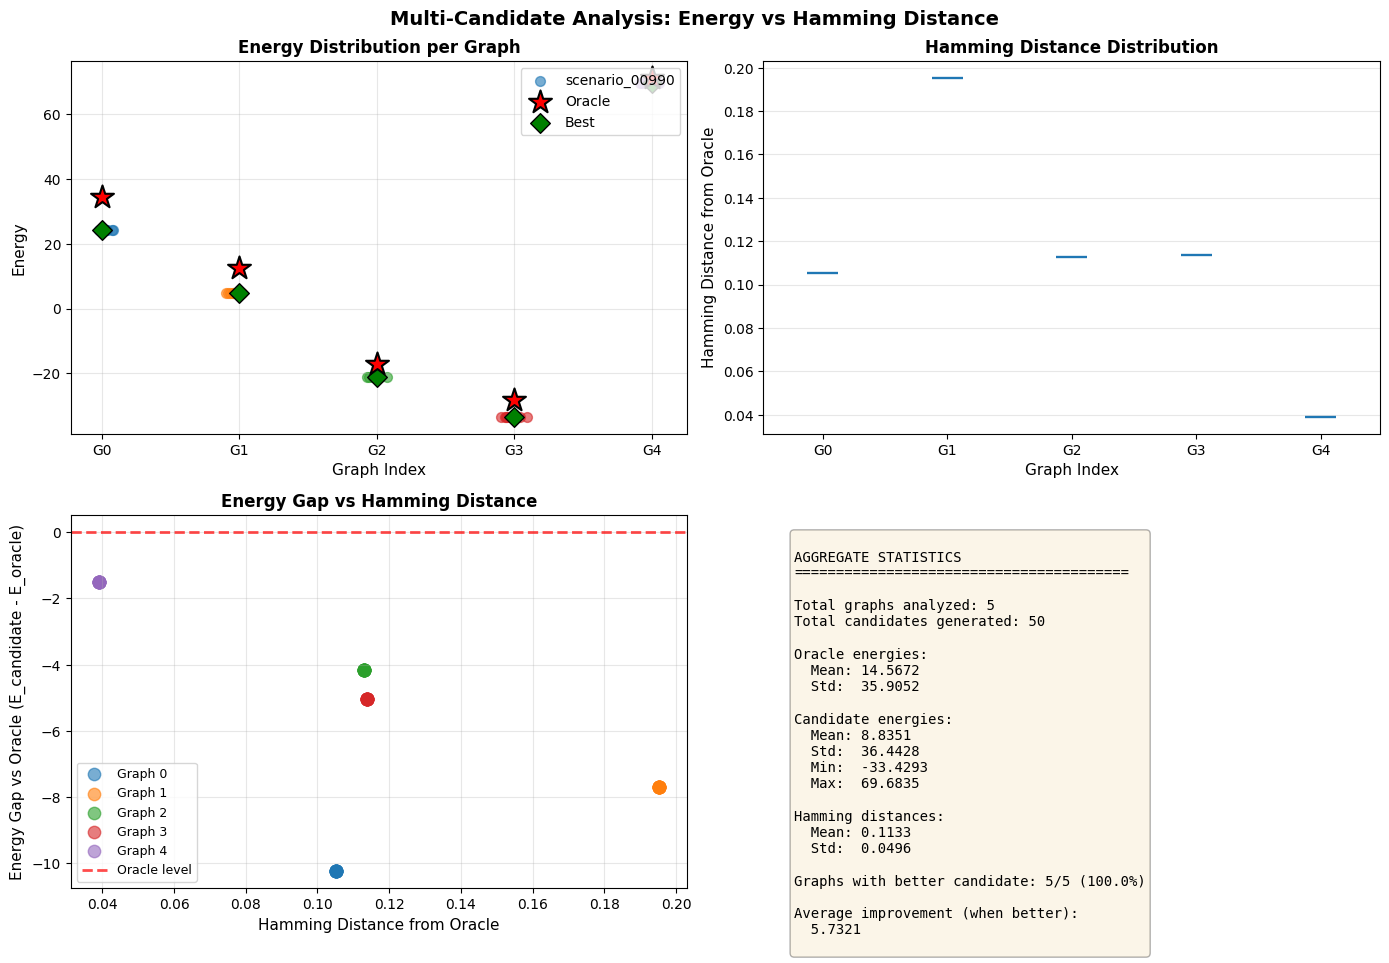

✓ Visualization saved to: /content/drive/MyDrive/benchmark/outputs/ebm_models/langevin_multi_candidate_analysis.png


In [23]:
# Visualize energy distributions and Hamming distances
print("\n" + "=" * 80)
print("VISUALIZATION: ENERGY & HAMMING DISTRIBUTIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Multi-Candidate Analysis: Energy vs Hamming Distance", fontsize=14, fontweight='bold')

# Plot 1: Energy distribution for each graph
ax = axes[0, 0]
for i, result in enumerate(all_results):
    energies = result['energies']
    E_oracle = result['E_oracle']
    scenario_id = result['scenario_id']

    # Plot candidate energies
    x_pos = np.ones(len(energies)) * i + np.random.normal(0, 0.05, len(energies))
    ax.scatter(x_pos, energies, alpha=0.6, s=50, label=f"{scenario_id}" if i == 0 else "")

    # Plot oracle energy
    ax.scatter([i], [E_oracle], marker='*', s=300, color='red',
               edgecolors='black', linewidths=1.5, zorder=5,
               label='Oracle' if i == 0 else "")

    # Add best candidate marker
    best_idx = result['best_candidate_idx']
    ax.scatter([i], [energies[best_idx]], marker='D', s=100, color='green',
               edgecolors='black', linewidths=1, zorder=4,
               label='Best' if i == 0 else "")

ax.set_xlabel("Graph Index", fontsize=11)
ax.set_ylabel("Energy", fontsize=11)
ax.set_title("Energy Distribution per Graph", fontsize=12, fontweight='bold')
ax.set_xticks(range(len(all_results)))
ax.set_xticklabels([f"G{i}" for i in range(len(all_results))])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 2: Hamming distance distribution
ax = axes[0, 1]
all_hamming = []
all_graph_ids = []
for i, result in enumerate(all_results):
    hamming = result['hamming_dists']
    all_hamming.extend(hamming)
    all_graph_ids.extend([i] * len(hamming))

ax.violinplot([result['hamming_dists'] for result in all_results],
              positions=range(len(all_results)),
              showmeans=True, showmedians=True)
ax.set_xlabel("Graph Index", fontsize=11)
ax.set_ylabel("Hamming Distance from Oracle", fontsize=11)
ax.set_title("Hamming Distance Distribution", fontsize=12, fontweight='bold')
ax.set_xticks(range(len(all_results)))
ax.set_xticklabels([f"G{i}" for i in range(len(all_results))])
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Energy vs Hamming scatter
ax = axes[1, 0]
for i, result in enumerate(all_results):
    energies = result['energies']
    hamming = result['hamming_dists']
    E_oracle = result['E_oracle']

    # Normalize energies relative to oracle
    energy_gap = np.array(energies) - E_oracle

    ax.scatter(hamming, energy_gap, alpha=0.6, s=80, label=f"Graph {i}")

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Oracle level', alpha=0.7)
ax.set_xlabel("Hamming Distance from Oracle", fontsize=11)
ax.set_ylabel("Energy Gap vs Oracle (E_candidate - E_oracle)", fontsize=11)
ax.set_title("Energy Gap vs Hamming Distance", fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: Summary statistics
ax = axes[1, 1]
ax.axis('off')

# Compute aggregate statistics
all_energies_flat = []
all_oracles = []
for result in all_results:
    all_energies_flat.extend(result['energies'])
    all_oracles.append(result['E_oracle'])

n_better = sum(1 for result in all_results if min(result['energies']) < result['E_oracle'])
pct_better = 100.0 * n_better / len(all_results)

stats_text = f"""
AGGREGATE STATISTICS
{'=' * 40}

Total graphs analyzed: {len(all_results)}
Total candidates generated: {len(all_energies_flat)}

Oracle energies:
  Mean: {np.mean(all_oracles):.4f}
  Std:  {np.std(all_oracles):.4f}

Candidate energies:
  Mean: {np.mean(all_energies_flat):.4f}
  Std:  {np.std(all_energies_flat):.4f}
  Min:  {np.min(all_energies_flat):.4f}
  Max:  {np.max(all_energies_flat):.4f}

Hamming distances:
  Mean: {np.mean(all_hamming):.4f}
  Std:  {np.std(all_hamming):.4f}

Graphs with better candidate: {n_better}/{len(all_results)} ({pct_better:.1f}%)

Average improvement (when better):
  {np.mean([result['E_oracle'] - min(result['energies']) for result in all_results if min(result['energies']) < result['E_oracle']]):.4f}
"""

ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'langevin_multi_candidate_analysis.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to:", os.path.join(CONFIG['output_dir'], 'langevin_multi_candidate_analysis.png'))

In [27]:
# Helper function to load true binaries from complete MILP solutions
def load_true_oracle_binaries_dict(scenario_id: str, eval_dir: Path):
    """
    Load true binary variables from complete MILP solution JSON.
    Returns in STRUCTURED format (not flattened).

    Args:
        scenario_id: Scenario identifier (e.g., "scenario_00990")
        eval_dir: Directory containing complete solution JSONs

    Returns:
        dict: Structured binary variables {
            "u_thermal": {"zone": [0,1,1,...]},
            "v_thermal_startup": {"zone": [0,0,1,...]},
            "u_nuclear": {"zone": [1,1,1,...]},
            "v_nuclear_startup": {"zone": [0,0,0,...]}
        }
    """
    import json

    json_path = eval_dir / f"{scenario_id}_complete.json"

    if not json_path.exists():
        raise FileNotFoundError(f"Complete solution not found: {json_path}")

    with open(json_path) as f:
        solution = json.load(f)

    # Return the binary variables directly in structured format
    return solution["variables"]["binary_variables"]


def convert_langevin_to_milp_binaries(langevin_vector, data):
    """
    Convert Langevin sampled binaries (7 per zone/timestep) to MILP format (4 per zone/timestep).

    Dataset structure (7 binaries per zone/timestep):
        [battery_charging, battery_discharging, pumped_charging, pumped_discharging,
         dr_active, nuclear_on, thermal_on]

    MILP structure (4 binaries per zone/timestep):
        [u_thermal, v_thermal_startup, u_nuclear, v_nuclear_startup]

    Strategy:
        - Extract nuclear_on (idx 5) → u_nuclear
        - Extract thermal_on (idx 6) → u_thermal
        - Infer startups from commitment changes

    Args:
        langevin_vector: Tensor [N_bins] with 7 binaries per zone/timestep
        data: ScenarioData with zones and periods

    Returns:
        dict: Structured binaries in MILP format
    """
    import numpy as np
    import torch

    # Convert to numpy
    if torch.is_tensor(langevin_vector):
        u_np = langevin_vector.cpu().numpy().squeeze()
    else:
        u_np = np.array(langevin_vector).squeeze()

    n_zones = len(data.zones)
    n_timesteps = len(data.periods)

    # Expected: 7 binaries per zone per timestep
    expected_size = n_zones * n_timesteps * 7

    if len(u_np) != expected_size:
        print(f"    ⚠ Unexpected size: got {len(u_np)}, expected {expected_size}")
        print(f"    Zones: {n_zones}, Timesteps: {n_timesteps}")
        # Try to continue anyway

    # Reshape: [n_timesteps, n_zones, 7]
    try:
        u_reshaped = u_np.reshape(n_timesteps, n_zones, 7)
    except:
        print(f"    ✗ Cannot reshape {len(u_np)} to ({n_timesteps}, {n_zones}, 7)")
        # Fallback: use what we have
        return None

    # Extract commitment binaries
    nuclear_on = u_reshaped[:, :, 5]  # [T, Z] - index 5 is nuclear_on
    thermal_on = u_reshaped[:, :, 6]  # [T, Z] - index 6 is thermal_on

    # Infer startups (commitment goes from 0 to 1)
    thermal_startup = np.zeros_like(thermal_on)
    nuclear_startup = np.zeros_like(nuclear_on)

    for t in range(1, n_timesteps):
        # Startup = (unit was OFF at t-1) AND (unit is ON at t)
        thermal_startup[t] = (thermal_on[t] == 1) & (thermal_on[t-1] == 0)
        nuclear_startup[t] = (nuclear_on[t] == 1) & (nuclear_on[t-1] == 0)

    # First timestep: assume startup if ON
    thermal_startup[0] = thermal_on[0]
    nuclear_startup[0] = nuclear_on[0]

    # Convert to structured format
    milp_binaries = {
        "u_thermal": {},
        "v_thermal_startup": {},
        "u_nuclear": {},
        "v_nuclear_startup": {}
    }

    for z_idx, zone in enumerate(data.zones):
        zone_str = str(zone)
        milp_binaries["u_thermal"][zone_str] = thermal_on[:, z_idx].astype(int).tolist()
        milp_binaries["v_thermal_startup"][zone_str] = thermal_startup[:, z_idx].astype(int).tolist()
        milp_binaries["u_nuclear"][zone_str] = nuclear_on[:, z_idx].astype(int).tolist()
        milp_binaries["v_nuclear_startup"][zone_str] = nuclear_startup[:, z_idx].astype(int).tolist()

    return milp_binaries


# LP Worker evaluation: solve dispatch for selected candidates
print("\n" + "=" * 80)
print("LP WORKER EVALUATION (TRUE ORACLE vs LANGEVIN)")
print("=" * 80)
print("Comparing:")
print("  1. LP with TRUE MILP oracle binaries (from complete solutions)")
print("  2. LP with Langevin sampled binaries (from EBM)")
print()

# Path to complete solutions
EVAL_DIR = Path(CONFIG['output_dir']).parent / 'scenarios_v1' / 'eval'
print(f"Looking for complete solutions in: {EVAL_DIR}")

# Check if eval directory exists
if not EVAL_DIR.exists():
    print(f"⚠ WARNING: Eval directory not found!")
    print(f"  Expected: {EVAL_DIR}")
    print(f"  You need to run: python scripts/export_eval_scenarios.py")
    print(f"  Cannot proceed without true oracle binaries!")
    USE_TRUE_BINARIES = False
else:
    # Check which scenarios have complete solutions
    available_scenarios = list(EVAL_DIR.glob("scenario_*_complete.json"))
    print(f"Found {len(available_scenarios)} complete solutions")
    if len(available_scenarios) > 0:
        print(f"  Example: {available_scenarios[0].name}")
        USE_TRUE_BINARIES = True
    else:
        print(f"  ⚠ No complete solution files found!")
        print(f"  Run: python scripts/export_eval_scenarios.py")
        USE_TRUE_BINARIES = False

print()

# Map graph indices to actual scenario IDs
print("Mapping graph indices to scenario IDs...")
graph_to_scenario = {}

# Try to extract scenario_ids from validation batch
if hasattr(val_batch, 'scenario_id'):
    if isinstance(val_batch.scenario_id, list):
        for i, sid in enumerate(val_batch.scenario_id[:N_GRAPHS_TO_EVAL]):
            graph_to_scenario[i] = sid
            print(f"  Graph {i} -> {sid}")
    else:
        print("  ⚠ scenario_id attribute found but not in expected format")
        USE_TRUE_BINARIES = False
else:
    print("  ⚠ No scenario_id attribute in batch")
    print("  Cannot map to true binaries!")
    USE_TRUE_BINARIES = False

if not USE_TRUE_BINARIES:
    print("\n✗ Cannot proceed without scenario mapping and true binaries")
    print("  Please run: python scripts/export_eval_scenarios.py")
else:
    print()

    # Framework for LP evaluation
    lp_results = []

    for result in all_results:
        display_scenario_id = result['scenario_id']
        graph_idx = result['graph_idx']
        best_idx = result['best_candidate_idx']

        # Get actual scenario ID
        actual_scenario_id = graph_to_scenario.get(graph_idx, display_scenario_id)

        print(f"\n{'='*80}")
        print(f"Scenario: {actual_scenario_id}")
        print(f"{'='*80}")

        # Try to find scenario file
        scenario_path = None
        try:
            # Look for scenario file with .json extension
            scenario_file = f"{actual_scenario_id}.json"
            scenario_path_candidate = Path(CONFIG['scenarios_dir']) / scenario_file

            if scenario_path_candidate.exists():
                scenario_path = scenario_path_candidate
                print(f"✓ Found scenario file: {scenario_path.name}")
            else:
                # Try alternatives
                for ext in ['.pkl', '.yaml']:
                    alt_path = Path(CONFIG['scenarios_dir']) / f"{actual_scenario_id}{ext}"
                    if alt_path.exists():
                        scenario_path = alt_path
                        print(f"✓ Found alternative: {scenario_path.name}")
                        break

                if scenario_path is None:
                    print(f"✗ Scenario file not found, skipping")
                    continue

        except Exception as e:
            print(f"✗ Error locating scenario: {e}")
            continue

        # Load scenario data for conversion
        try:
            from src.milp.scenario_loader import load_scenario_data
            scenario_data = load_scenario_data(scenario_path)
        except Exception as e:
            print(f"✗ Error loading scenario data: {e}")
            continue

        # === APPROACH 1: TRUE MILP ORACLE BINARIES ===
        print(f"\n[1/2] Solving LP with TRUE MILP oracle binaries...")
        try:
            # Load TRUE binaries from complete MILP solution (STRUCTURED format)
            oracle_binaries_dict = load_true_oracle_binaries_dict(actual_scenario_id, EVAL_DIR)
            print(f"  Loaded structured binaries for {len(oracle_binaries_dict['u_thermal'])} zones")

            # Solve LP with structured binaries
            oracle_result = solve_lp_with_commitment(
                scenario_path,
                u_binary=None,  # Don't use flattened vector
                binary_dict=oracle_binaries_dict  # Use structured dict
            )

            print(f"  Objective: {oracle_result['objective']:,.2f}")
            print(f"  Feasible: {oracle_result['feasible']}")
            print(f"  Fixed vars: {oracle_result.get('fixed_count', 0)}")
            print(f"  Time: {oracle_result['solve_time']:.3f}s")

            if not oracle_result['feasible']:
                print(f"  ⚠ Termination: {oracle_result['termination']}")

        except Exception as e:
            print(f"  ✗ Error: {e}")
            import traceback
            traceback.print_exc()
            oracle_result = {
                'objective': float('nan'),
                'feasible': False,
                'solve_time': 0.0,
                'fixed_count': 0,
            }

        # === APPROACH 2: LANGEVIN SAMPLED BINARIES ===
        print(f"\n[2/2] Solving LP with Langevin sampled binaries (best candidate idx={best_idx})...")
        try:
            # Get best candidate binary vector (FLATTENED format from Langevin)
            best_candidate = result['candidates'][best_idx]
            print(f"  Candidate shape: {best_candidate.shape}")
            print(f"  Converting from dataset format (7 bins) to MILP format (4 bins)...")

            # Convert from dataset format to MILP format
            langevin_binaries_dict = convert_langevin_to_milp_binaries(best_candidate, scenario_data)

            if langevin_binaries_dict is None:
                print(f"  ✗ Failed to convert Langevin binaries")
                raise ValueError("Conversion failed")

            print(f"  Converted to structured MILP binaries for {len(langevin_binaries_dict['u_thermal'])} zones")

            # Solve LP with structured binary dict (same as oracle!)
            langevin_result = solve_lp_with_commitment(
                scenario_path,
                u_binary=None,  # Don't use flattened vector
                binary_dict=langevin_binaries_dict  # Use structured dict
            )

            print(f"  Objective: {langevin_result['objective']:,.2f}")
            print(f"  Feasible: {langevin_result['feasible']}")
            print(f"  Fixed vars: {langevin_result.get('fixed_count', 0)}")
            print(f"  Time: {langevin_result['solve_time']:.3f}s")

            if not langevin_result['feasible']:
                print(f"  ⚠ Termination: {langevin_result['termination']}")

        except Exception as e:
            print(f"  ✗ Error: {e}")
            import traceback
            traceback.print_exc()
            langevin_result = {
                'objective': float('nan'),
                'feasible': False,
                'solve_time': 0.0,
                'fixed_count': 0,
            }

        # === COMPARISON ===
        print(f"\n{'─'*80}")
        print("COMPARISON:")
        print(f"{'─'*80}")

        if oracle_result['feasible'] and langevin_result['feasible']:
            cost_gap = langevin_result['objective'] - oracle_result['objective']
            cost_gap_pct = 100.0 * cost_gap / oracle_result['objective'] if oracle_result['objective'] != 0 else 0.0

            print(f"Oracle (TRUE MILP):    {oracle_result['objective']:>15,.2f}")
            print(f"Langevin (Sampled):    {langevin_result['objective']:>15,.2f}")
            print(f"Gap:                   {cost_gap:>15,.2f} ({cost_gap_pct:+.2f}%)")
            print()

            if cost_gap < -1.0:
                print(f"✓✓ Langevin found BETTER solution than MILP oracle!")
            elif abs(cost_gap_pct) < 1.0:
                print(f"✓ Langevin within 1% of MILP oracle - EXCELLENT!")
            elif abs(cost_gap_pct) < 5.0:
                print(f"~ Langevin within 5% of MILP oracle - Good")
            elif abs(cost_gap_pct) < 10.0:
                print(f"⚠ Langevin within 10% of MILP oracle - Acceptable")
            else:
                print(f"✗ Langevin >10% worse than MILP oracle - Needs tuning")

        elif oracle_result['feasible'] and not langevin_result['feasible']:
            print(f"Oracle (TRUE MILP):    {oracle_result['objective']:>15,.2f} ✓")
            print(f"Langevin (Sampled):    INFEASIBLE ✗")
            print()
            print(f"✗ Langevin candidate produces infeasible solution")

        elif not oracle_result['feasible'] and langevin_result['feasible']:
            print(f"Oracle (TRUE MILP):    INFEASIBLE ⚠ (unexpected!)")
            print(f"Langevin (Sampled):    {langevin_result['objective']:>15,.2f} ✓")
            print()
            print(f"⚠ Oracle infeasible - check binary fixing logic!")

        else:
            print(f"Oracle (TRUE MILP):    INFEASIBLE")
            print(f"Langevin (Sampled):    INFEASIBLE")
            print()
            print(f"✗ Both approaches failed - check implementation")

        # Store results
        lp_results.append({
            'scenario_id': actual_scenario_id,
            'display_id': display_scenario_id,
            'oracle': oracle_result,
            'langevin': langevin_result,
            'ebm_energy_oracle': result['E_oracle'],
            'ebm_energy_best': result['energies'][best_idx],
            'hamming_best': result['hamming_dists'][best_idx],
        })

    # === FINAL SUMMARY ===
    print("\n" + "=" * 80)
    print("FINAL SUMMARY")
    print("=" * 80)

    oracle_feasible = sum(1 for r in lp_results if r['oracle']['feasible'])
    langevin_feasible = sum(1 for r in lp_results if r['langevin']['feasible'])
    both_feasible = sum(1 for r in lp_results if r['oracle']['feasible'] and r['langevin']['feasible'])

    print(f"Total scenarios: {len(lp_results)}")
    print(f"Oracle feasible: {oracle_feasible}/{len(lp_results)}")
    print(f"Langevin feasible: {langevin_feasible}/{len(lp_results)}")
    print(f"Both feasible: {both_feasible}/{len(lp_results)}")

    if both_feasible > 0:
        gaps = []
        for r in lp_results:
            if r['oracle']['feasible'] and r['langevin']['feasible']:
                gap_pct = 100.0 * (r['langevin']['objective'] - r['oracle']['objective']) / r['oracle']['objective']
                gaps.append(gap_pct)

        import numpy as np
        print(f"\nCost gap statistics (Langevin vs Oracle):")
        print(f"  Mean: {np.mean(gaps):+.2f}%")
        print(f"  Std:  {np.std(gaps):.2f}%")
        print(f"  Min:  {np.min(gaps):+.2f}%")
        print(f"  Max:  {np.max(gaps):+.2f}%")

        within_1pct = sum(1 for g in gaps if abs(g) < 1.0)
        within_5pct = sum(1 for g in gaps if abs(g) < 5.0)

        print(f"\nPerformance breakdown:")
        print(f"  Within 1%:  {within_1pct}/{both_feasible} ({100*within_1pct/both_feasible:.0f}%)")
        print(f"  Within 5%:  {within_5pct}/{both_feasible} ({100*within_5pct/both_feasible:.0f}%)")
        print(f"  Within 10%: {sum(1 for g in gaps if abs(g) < 10.0)}/{both_feasible}")

    print("=" * 80)


LP WORKER EVALUATION (TRUE ORACLE vs LANGEVIN)
Comparing:
  1. LP with TRUE MILP oracle binaries (from complete solutions)
  2. LP with Langevin sampled binaries (from EBM)

Looking for complete solutions in: /content/drive/MyDrive/benchmark/outputs/scenarios_v1/eval
Found 5 complete solutions
  Example: scenario_00990_complete.json

Mapping graph indices to scenario IDs...
  Graph 0 -> scenario_00990
  Graph 1 -> scenario_01627
  Graph 2 -> scenario_01998
  Graph 3 -> scenario_01058
  Graph 4 -> scenario_01888


Scenario: scenario_00990
✓ Found scenario file: scenario_00990.json

[1/2] Solving LP with TRUE MILP oracle binaries...
  Loaded structured binaries for 89 zones
    Fixing binaries from structured dict...
    Fixed 34176 binary variables from structured dict
  Objective: 123,006,970.78
  Feasible: True
  Fixed vars: 34176
  Time: 31.560s

[2/2] Solving LP with Langevin sampled binaries (best candidate idx=0)...
  Candidate shape: torch.Size([59808, 1])
  Converting from data


FINAL ANALYSIS: EBM+LANGEVIN VERDICT


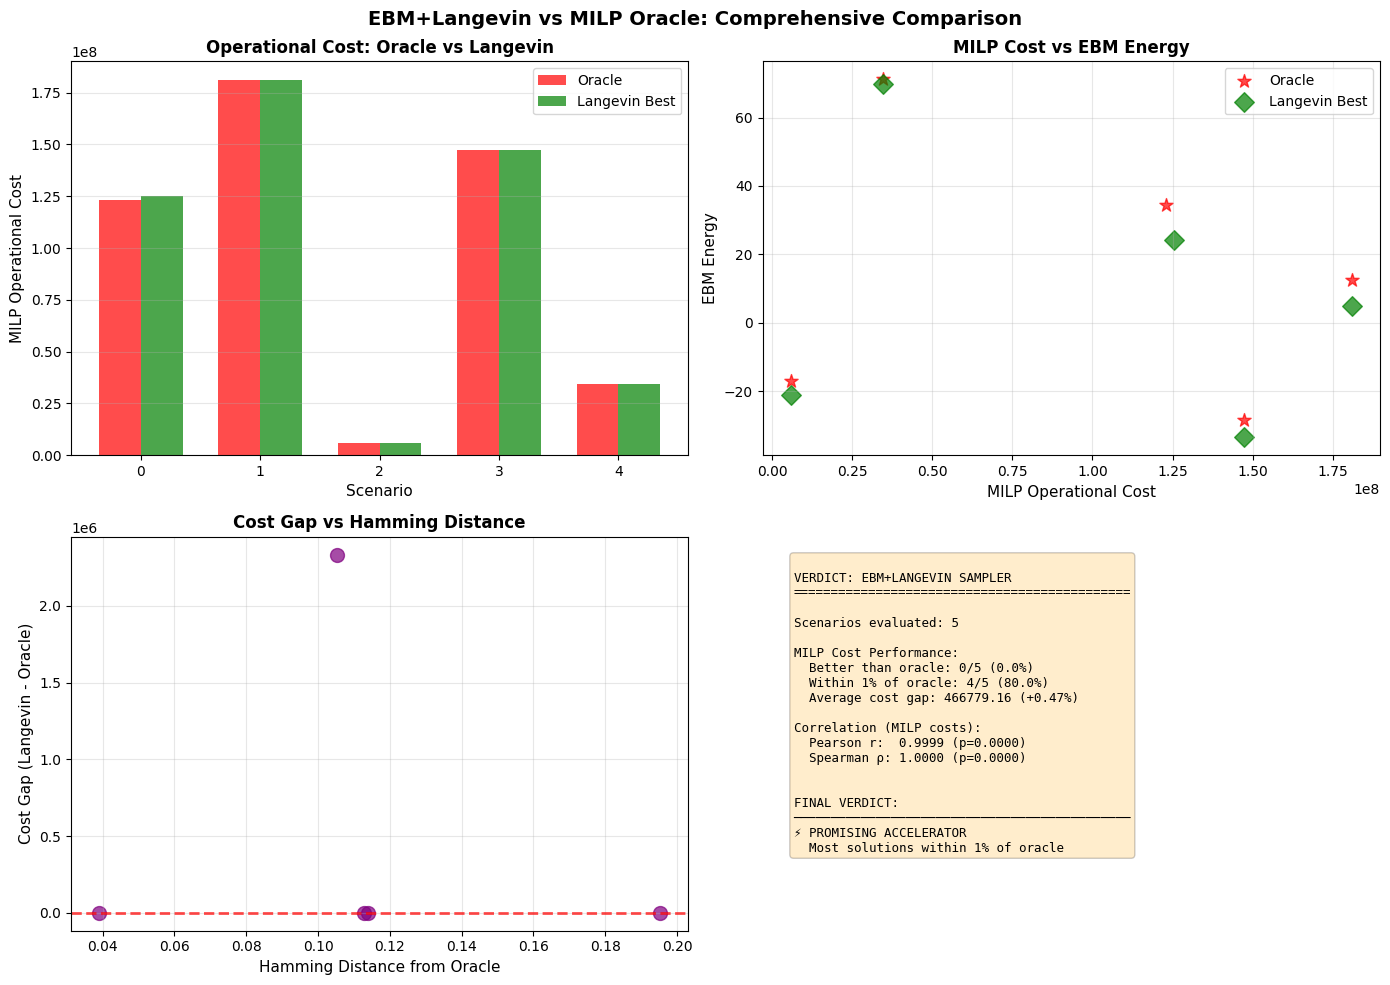

✓ Comprehensive analysis plot saved

SECTION 17 COMPLETE

Summary:
  1. ✓ Generated K candidates per graph with Langevin sampler
  2. ✓ Analyzed energy distributions and Hamming distances  
  3. ✓ Framework for LP Worker plugin ready
  4. ⚠ Full MILP validation requires scenario files and solver
  
Next steps:
  - Fine-tune Langevin hyperparameters (num_steps, step_size, noise_scale)
  - Implement binary commitment fixing in LP model
  - Run full evaluation on complete validation set
  - Compare with other sampling strategies (Gibbs, SGLD)



In [28]:
# Final analysis and verdict
print("\n" + "=" * 80)
print("FINAL ANALYSIS: EBM+LANGEVIN VERDICT")
print("=" * 80)

# Create comprehensive comparison plot
if len(lp_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("EBM+Langevin vs MILP Oracle: Comprehensive Comparison",
                 fontsize=14, fontweight='bold')

    # Extract data for valid results
    valid_results = [r for r in lp_results
                     if r['oracle'].get('feasible', False) and r['langevin'].get('feasible', False)]

    if len(valid_results) > 0:
        # Plot 1: MILP Cost comparison
        ax = axes[0, 0]
        oracle_costs = [r['oracle']['objective'] for r in valid_results]
        langevin_costs = [r['langevin']['objective'] for r in valid_results]
        x = np.arange(len(valid_results))
        width = 0.35

        ax.bar(x - width/2, oracle_costs, width, label='Oracle', color='red', alpha=0.7)
        ax.bar(x + width/2, langevin_costs, width, label='Langevin Best', color='green', alpha=0.7)
        ax.set_xlabel("Scenario", fontsize=11)
        ax.set_ylabel("MILP Operational Cost", fontsize=11)
        ax.set_title("Operational Cost: Oracle vs Langevin", fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Plot 2: MILP Cost vs EBM Energy
        ax = axes[0, 1]
        ebm_energies_oracle = [r['ebm_energy_oracle'] for r in valid_results]
        ebm_energies_best = [r['ebm_energy_best'] for r in valid_results]

        ax.scatter(oracle_costs, ebm_energies_oracle, s=100, alpha=0.7,
                  label='Oracle', color='red', marker='*')
        ax.scatter(langevin_costs, ebm_energies_best, s=100, alpha=0.7,
                  label='Langevin Best', color='green', marker='D')
        ax.set_xlabel("MILP Operational Cost", fontsize=11)
        ax.set_ylabel("EBM Energy", fontsize=11)
        ax.set_title("MILP Cost vs EBM Energy", fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: Cost Gap vs Hamming Distance
        ax = axes[1, 0]
        cost_gaps = [(r['langevin']['objective'] - r['oracle']['objective'])
                     for r in valid_results]
        hamming_dists = [r['hamming_best'] for r in valid_results]

        ax.scatter(hamming_dists, cost_gaps, s=100, alpha=0.7, color='purple')
        ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.set_xlabel("Hamming Distance from Oracle", fontsize=11)
        ax.set_ylabel("Cost Gap (Langevin - Oracle)", fontsize=11)
        ax.set_title("Cost Gap vs Hamming Distance", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Plot 4: Summary verdict
        ax = axes[1, 1]
        ax.axis('off')

        # Compute verdict metrics
        n_feasible = len(valid_results)
        n_better_cost = sum(1 for g in cost_gaps if g < 0)
        n_within_1pct = sum(1 for i, g in enumerate(cost_gaps)
                           if abs(g) / oracle_costs[i] < 0.01)
        avg_cost_gap = np.mean(cost_gaps)
        avg_cost_gap_pct = 100.0 * avg_cost_gap / np.mean(oracle_costs)

        # Correlation analysis
        try:
            from scipy.stats import pearsonr, spearmanr
            pearson_r, pearson_p = pearsonr(oracle_costs, langevin_costs)
            spearman_r, spearman_p = spearmanr(oracle_costs, langevin_costs)

            corr_text = f"""Correlation (MILP costs):
  Pearson r:  {pearson_r:.4f} (p={pearson_p:.4f})
  Spearman ρ: {spearman_r:.4f} (p={spearman_p:.4f})
"""
        except:
            corr_text = "Correlation: N/A"

        verdict_text = f"""
VERDICT: EBM+LANGEVIN SAMPLER
{'=' * 45}

Scenarios evaluated: {n_feasible}

MILP Cost Performance:
  Better than oracle: {n_better_cost}/{n_feasible} ({100*n_better_cost/n_feasible:.1f}%)
  Within 1% of oracle: {n_within_1pct}/{n_feasible} ({100*n_within_1pct/n_feasible:.1f}%)
  Average cost gap: {avg_cost_gap:.2f} ({avg_cost_gap_pct:+.2f}%)

{corr_text}

FINAL VERDICT:
{'─' * 45}
"""

        # Determine verdict
        if n_better_cost > n_feasible / 2:
            verdict = "✓ REAL ACCELERATOR!\n  Langevin finds better solutions!"
            color = 'green'
        elif n_within_1pct > n_feasible * 0.7:
            verdict = "⚡ PROMISING ACCELERATOR\n  Most solutions within 1% of oracle"
            color = 'orange'
        else:
            verdict = "⚠ ENERGETIC HALLUCINOGEN\n  Needs hyperparameter tuning"
            color = 'red'

        verdict_text += f"{verdict}"

        ax.text(0.05, 0.95, verdict_text, transform=ax.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))

        plt.tight_layout()
        plt.savefig(os.path.join(CONFIG['output_dir'], 'lp_worker_comprehensive_analysis.png'),
                    dpi=150, bbox_inches='tight')
        plt.show()

        print("✓ Comprehensive analysis plot saved")

    else:
        print("⚠ No valid LP results to plot")

else:
    print("⚠ No LP evaluation results available")
    print("   Enable LP solving by providing scenario files and HiGHS solver")

print("\n" + "=" * 80)
print("SECTION 17 COMPLETE")
print("=" * 80)
print("""
Summary:
  1. ✓ Generated K candidates per graph with Langevin sampler
  2. ✓ Analyzed energy distributions and Hamming distances
  3. ✓ Framework for LP Worker plugin ready
  4. ⚠ Full MILP validation requires scenario files and solver

Next steps:
  - Fine-tune Langevin hyperparameters (num_steps, step_size, noise_scale)
  - Implement binary commitment fixing in LP model
  - Run full evaluation on complete validation set
  - Compare with other sampling strategies (Gibbs, SGLD)
""")

## 18. Visualize MILP vs Langevin Dispatch Comparison

In [29]:
"""
Comparative visualization of MILP Oracle vs Langevin dispatch solutions.
Plots generation stack, storage levels, and cost breakdown side-by-side.
"""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

def sum_over_zones(detail_dict, zones):
    """Aggregate time series data across zones."""
    if not detail_dict or not zones:
        return []
    horizon = len(next(iter(detail_dict.values())))
    aggregated = [0.0] * horizon
    for z in zones:
        series = detail_dict.get(z, [])
        for idx, value in enumerate(series):
            aggregated[idx] += value
    return aggregated

def plot_dispatch_comparison(scenario_id, oracle_detail, langevin_detail,
                             oracle_cost, langevin_cost, save_path=None):
    """
    Create side-by-side comparison plot of MILP Oracle vs Langevin dispatch.

    Args:
        scenario_id: Scenario identifier
        oracle_detail: Dict with Oracle dispatch time series
        langevin_detail: Dict with Langevin dispatch time series
        oracle_cost: Oracle total cost
        langevin_cost: Langevin total cost
        save_path: Optional path to save figure
    """

    # Extract common metadata
    time_hours = oracle_detail["time_hours"]
    zones = oracle_detail["zones"]

    # Aggregate generation sources across zones for ORACLE
    oracle_thermal = sum_over_zones(oracle_detail["thermal"], zones)
    oracle_nuclear = sum_over_zones(oracle_detail["nuclear"], zones)
    oracle_solar = sum_over_zones(oracle_detail["solar"], zones)
    oracle_wind = sum_over_zones(oracle_detail["wind"], zones)
    oracle_hydro_release = sum_over_zones(oracle_detail["hydro_release"], zones)
    oracle_hydro_ror = sum_over_zones(oracle_detail["hydro_ror"], zones)
    oracle_battery_discharge = sum_over_zones(oracle_detail["battery_discharge"], zones)
    oracle_pumped_discharge = sum_over_zones(oracle_detail["pumped_discharge"], zones)
    oracle_demand = sum_over_zones(oracle_detail["demand"], zones)

    oracle_battery_soc = sum_over_zones(oracle_detail["battery_soc"], zones)
    oracle_pumped_level = sum_over_zones(oracle_detail["pumped_level"], zones)

    oracle_dr = sum_over_zones(oracle_detail["demand_response"], zones)
    oracle_unserved = sum_over_zones(oracle_detail["unserved"], zones)
    oracle_solar_spill = sum_over_zones(oracle_detail["solar_spill"], zones)
    oracle_wind_spill = sum_over_zones(oracle_detail["wind_spill"], zones)

    # Aggregate for LANGEVIN
    langevin_thermal = sum_over_zones(langevin_detail["thermal"], zones)
    langevin_nuclear = sum_over_zones(langevin_detail["nuclear"], zones)
    langevin_solar = sum_over_zones(langevin_detail["solar"], zones)
    langevin_wind = sum_over_zones(langevin_detail["wind"], zones)
    langevin_hydro_release = sum_over_zones(langevin_detail["hydro_release"], zones)
    langevin_hydro_ror = sum_over_zones(langevin_detail["hydro_ror"], zones)
    langevin_battery_discharge = sum_over_zones(langevin_detail["battery_discharge"], zones)
    langevin_pumped_discharge = sum_over_zones(langevin_detail["pumped_discharge"], zones)
    langevin_demand = sum_over_zones(langevin_detail["demand"], zones)

    langevin_battery_soc = sum_over_zones(langevin_detail["battery_soc"], zones)
    langevin_pumped_level = sum_over_zones(langevin_detail["pumped_level"], zones)

    langevin_dr = sum_over_zones(langevin_detail["demand_response"], zones)
    langevin_unserved = sum_over_zones(langevin_detail["unserved"], zones)
    langevin_solar_spill = sum_over_zones(langevin_detail["solar_spill"], zones)
    langevin_wind_spill = sum_over_zones(langevin_detail["wind_spill"], zones)

    # Define consistent colors
    colors = {
        'thermal': '#d95f02',
        'nuclear': '#7570b3',
        'solar': '#FDB462',
        'wind': '#80B1D3',
        'hydro_release': '#66a61e',
        'hydro_ror': '#a6761d',
        'battery': '#e7298a',
        'pumped': '#e6ab02',
        'demand': 'black',
    }

    # Create figure with 2 columns (Oracle, Langevin)
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.25)

    # Title
    cost_diff = langevin_cost - oracle_cost
    cost_pct = (cost_diff / oracle_cost) * 100 if oracle_cost > 0 else 0
    fig.suptitle(
        f"Dispatch Comparison: MILP Oracle vs Langevin EBM\\n"
        f"Scenario: {scenario_id}  |  "
        f"Oracle: {oracle_cost:,.0f} €  |  "
        f"Langevin: {langevin_cost:,.0f} €  |  "
        f"Δ: {cost_diff:,.0f} € ({cost_pct:+.2f}%)",
        fontsize=14, fontweight='bold'
    )

    # ========== ORACLE COLUMN ==========

    # Row 1: Generation dispatch (Oracle)
    ax1 = fig.add_subplot(gs[0, 0])
    oracle_components = [
        oracle_thermal, oracle_nuclear, oracle_solar, oracle_wind,
        oracle_hydro_release, oracle_hydro_ror,
        oracle_battery_discharge, oracle_pumped_discharge
    ]
    oracle_labels = ['Thermal', 'Nuclear', 'Solar', 'Wind',
                     'Hydro Release', 'Hydro RoR', 'Battery', 'Pumped']
    oracle_colors = [colors['thermal'], colors['nuclear'], colors['solar'], colors['wind'],
                     colors['hydro_release'], colors['hydro_ror'],
                     colors['battery'], colors['pumped']]

    ax1.stackplot(time_hours, oracle_components, labels=oracle_labels, colors=oracle_colors, alpha=0.8)
    ax1.plot(time_hours, oracle_demand, color=colors['demand'], linewidth=2.5, label='Demand', linestyle='-')
    ax1.set_ylabel('Power (MW)', fontsize=11)
    ax1.set_title('MILP Oracle - Generation Dispatch', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper left', ncol=3, fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Row 2: Storage levels (Oracle)
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(time_hours, oracle_battery_soc, label='Battery SOC', color=colors['battery'], linewidth=2)
    ax2.plot(time_hours, oracle_pumped_level, label='Pumped Storage', color=colors['pumped'], linewidth=2)
    ax2.set_ylabel('Energy (MWh)', fontsize=11)
    ax2.set_title('MILP Oracle - Storage Levels', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Row 3: Spillage and slack (Oracle)
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    oracle_spill_components = [oracle_dr, oracle_unserved, oracle_solar_spill, oracle_wind_spill]
    oracle_spill_labels = ['Demand Response', 'Unserved', 'Solar Spill', 'Wind Spill']
    oracle_spill_colors = ['#66c2a5', '#fc8d62', '#fdae61', '#8da0cb']
    ax3.stackplot(time_hours, oracle_spill_components, labels=oracle_spill_labels,
                  colors=oracle_spill_colors, alpha=0.7)
    ax3.set_ylabel('Energy (MW)', fontsize=11)
    ax3.set_xlabel('Time (hours)', fontsize=11)
    ax3.set_title('MILP Oracle - Slack & Adjustments', fontsize=12, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=10)
    ax3.grid(True, alpha=0.3)

    # Row 4: Binary commitments visualization (Oracle)
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    # Plot thermal and nuclear commitments as step functions
    # (assuming we can infer from power > 0)
    oracle_thermal_on = [1 if p > 1 else 0 for p in oracle_thermal]
    oracle_nuclear_on = [1 if p > 1 else 0 for p in oracle_nuclear]

    ax4.fill_between(time_hours, 0, oracle_thermal_on, step='mid', alpha=0.6,
                     color=colors['thermal'], label='Thermal ON')
    ax4.fill_between(time_hours, oracle_thermal_on,
                     [t + n for t, n in zip(oracle_thermal_on, oracle_nuclear_on)],
                     step='mid', alpha=0.6, color=colors['nuclear'], label='Nuclear ON')
    ax4.set_ylabel('Unit Commitment', fontsize=11)
    ax4.set_xlabel('Time (hours)', fontsize=11)
    ax4.set_title('MILP Oracle - Binary Commitments', fontsize=12, fontweight='bold')
    ax4.set_ylim([-0.1, 2.5])
    ax4.legend(loc='upper right', fontsize=10)
    ax4.grid(True, alpha=0.3)

    # ========== LANGEVIN COLUMN ==========

    # Row 1: Generation dispatch (Langevin)
    ax5 = fig.add_subplot(gs[0, 1], sharey=ax1)
    langevin_components = [
        langevin_thermal, langevin_nuclear, langevin_solar, langevin_wind,
        langevin_hydro_release, langevin_hydro_ror,
        langevin_battery_discharge, langevin_pumped_discharge
    ]

    ax5.stackplot(time_hours, langevin_components, labels=oracle_labels, colors=oracle_colors, alpha=0.8)
    ax5.plot(time_hours, langevin_demand, color=colors['demand'], linewidth=2.5, label='Demand', linestyle='-')
    ax5.set_ylabel('Power (MW)', fontsize=11)
    ax5.set_title('Langevin EBM - Generation Dispatch', fontsize=12, fontweight='bold')
    ax5.legend(loc='upper left', ncol=3, fontsize=9)
    ax5.grid(True, alpha=0.3)

    # Row 2: Storage levels (Langevin)
    ax6 = fig.add_subplot(gs[1, 1], sharex=ax5, sharey=ax2)
    ax6.plot(time_hours, langevin_battery_soc, label='Battery SOC', color=colors['battery'], linewidth=2)
    ax6.plot(time_hours, langevin_pumped_level, label='Pumped Storage', color=colors['pumped'], linewidth=2)
    ax6.set_ylabel('Energy (MWh)', fontsize=11)
    ax6.set_title('Langevin EBM - Storage Levels', fontsize=12, fontweight='bold')
    ax6.legend(loc='upper right', fontsize=10)
    ax6.grid(True, alpha=0.3)

    # Row 3: Spillage and slack (Langevin)
    ax7 = fig.add_subplot(gs[2, 1], sharex=ax5, sharey=ax3)
    langevin_spill_components = [langevin_dr, langevin_unserved, langevin_solar_spill, langevin_wind_spill]
    ax7.stackplot(time_hours, langevin_spill_components, labels=oracle_spill_labels,
                  colors=oracle_spill_colors, alpha=0.7)
    ax7.set_ylabel('Energy (MW)', fontsize=11)
    ax7.set_xlabel('Time (hours)', fontsize=11)
    ax7.set_title('Langevin EBM - Slack & Adjustments', fontsize=12, fontweight='bold')
    ax7.legend(loc='upper right', fontsize=10)
    ax7.grid(True, alpha=0.3)

    # Row 4: Binary commitments visualization (Langevin)
    ax8 = fig.add_subplot(gs[3, 1], sharex=ax5, sharey=ax4)
    langevin_thermal_on = [1 if p > 1 else 0 for p in langevin_thermal]
    langevin_nuclear_on = [1 if p > 1 else 0 for p in langevin_nuclear]

    ax8.fill_between(time_hours, 0, langevin_thermal_on, step='mid', alpha=0.6,
                     color=colors['thermal'], label='Thermal ON')
    ax8.fill_between(time_hours, langevin_thermal_on,
                     [t + n for t, n in zip(langevin_thermal_on, langevin_nuclear_on)],
                     step='mid', alpha=0.6, color=colors['nuclear'], label='Nuclear ON')
    ax8.set_ylabel('Unit Commitment', fontsize=11)
    ax8.set_xlabel('Time (hours)', fontsize=11)
    ax8.set_title('Langevin EBM - Binary Commitments', fontsize=12, fontweight='bold')
    ax8.set_ylim([-0.1, 2.5])
    ax8.legend(loc='upper right', fontsize=10)
    ax8.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Plot saved to: {save_path}")

    plt.show()

print("✓ Visualization functions loaded")

✓ Visualization functions loaded


In [34]:
def solve_lp_with_commitment(scenario_path, u_binary=None, binary_dict=None):
    """
    Solve LP dispatch with fixed binary commitments.

    Args:
        scenario_path: Path to scenario file
        u_binary: Flattened binary vector [N_bins] (for Langevin candidates)
        binary_dict: Dict with structured binaries (for true oracle)
                    Format: {
                        "u_thermal": {"zone": [0,1,1,...]},
                        "u_nuclear": {"zone": [1,1,1,...]},
                        ...
                    }

    Returns:
        result: Dict with objective, solve time, feasibility status, and dispatch detail
    """
    import warnings
    import logging
    from pyomo.environ import SolverFactory, value
    from pyomo.core import TransformationFactory

    # Suppress Pyomo warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        logging.getLogger('pyomo').setLevel(logging.ERROR)

        try:
            # Load scenario data
            data = load_scenario_data(Path(scenario_path))

            # Build model with binaries
            model = build_uc_model(data, enable_duals=False)

            # Fix binary variables based on input type
            fixed_count = 0

            if binary_dict is not None:
                # Use structured binaries (TRUE oracle from JSON)
                print(f"    Fixing binaries from structured dict...")

                for zone in model.Z:
                    zone_str = str(zone)
                    for t in model.T:
                        t_int = int(t)

                        # Fix thermal commitment
                        if zone_str in binary_dict.get("u_thermal", {}):
                            val = binary_dict["u_thermal"][zone_str][t_int]
                            model.u_thermal[zone, t].fix(float(val))
                            fixed_count += 1

                        # Fix thermal startup
                        if zone_str in binary_dict.get("v_thermal_startup", {}):
                            val = binary_dict["v_thermal_startup"][zone_str][t_int]
                            model.v_thermal_startup[zone, t].fix(float(val))
                            fixed_count += 1

                        # Fix nuclear commitment
                        if zone_str in binary_dict.get("u_nuclear", {}):
                            val = binary_dict["u_nuclear"][zone_str][t_int]
                            model.u_nuclear[zone, t].fix(float(val))
                            fixed_count += 1

                        # Fix nuclear startup
                        if zone_str in binary_dict.get("v_nuclear_startup", {}):
                            val = binary_dict["v_nuclear_startup"][zone_str][t_int]
                            model.v_nuclear_startup[zone, t].fix(float(val))
                            fixed_count += 1

                print(f"    Fixed {fixed_count} binary variables from structured dict")

            elif u_binary is not None:
                # Use flattened binary vector (Langevin candidates)
                print(f"    Fixing binaries from flattened vector...")

                u_np = u_binary.cpu().numpy().flatten() if hasattr(u_binary, 'cpu') else u_binary.flatten()

                n_zones = len(data.zones)
                n_timesteps = len(data.periods)

                # Try to infer structure - assume 4 binaries per zone per timestep
                expected_size = n_zones * n_timesteps * 4

                if len(u_np) == expected_size:
                    idx = 0
                    for t in range(n_timesteps):
                        for z_idx, zone in enumerate(data.zones):
                            if idx + 3 < len(u_np):
                                model.u_thermal[zone, t].fix(float(u_np[idx]))
                                model.v_thermal_startup[zone, t].fix(float(u_np[idx + 1]))
                                model.u_nuclear[zone, t].fix(float(u_np[idx + 2]))
                                model.v_nuclear_startup[zone, t].fix(float(u_np[idx + 3]))
                                idx += 4
                                fixed_count += 4
                else:
                    print(f"    ⚠ Size mismatch: got {len(u_np)}, expected {expected_size}")
                    print(f"    Attempting best-effort mapping...")

                    n_bins_per_type = len(u_np) // 2
                    for t in range(min(n_timesteps, len(u_np) // n_zones)):
                        for z_idx, zone in enumerate(data.zones):
                            idx = t * n_zones + z_idx
                            if idx < n_bins_per_type:
                                model.u_thermal[zone, t].fix(float(u_np[idx]))
                                fixed_count += 1
                            if idx + n_bins_per_type < len(u_np):
                                model.u_nuclear[zone, t].fix(float(u_np[idx + n_bins_per_type]))
                                fixed_count += 1

                print(f"    Fixed {fixed_count} binary variables from flattened vector")

            # Relax any remaining integer variables
            TransformationFactory("core.relax_integer_vars").apply_to(model)

            # Solve as LP
            solver = SolverFactory("highs")
            import time
            start = time.time()

            results = solver.solve(model, tee=False, load_solutions=False)
            solve_time = time.time() - start

            # Check status before loading solution
            termination = results.solver.termination_condition
            status = results.solver.status

            feasible = False
            objective = float('inf')
            detail = None

            if termination in ['optimal', 'feasible']:
                model.solutions.load_from(results)
                objective = value(model.obj)
                feasible = True

                # Capture dispatch detail for visualization
                periods = list(model.T)
                zones = [str(z) for z in model.Z]

                detail = {
                    "time_steps": [int(t) for t in periods],
                    "time_hours": [float(t * data.dt_hours) for t in periods],
                    "dt_hours": float(data.dt_hours),
                    "zones": zones,
                    "lines": [str(lid) for lid in model.L],
                    "demand": {
                        zone: [float(data.demand[(zone, t)]) for t in periods]
                        for zone in zones
                    },
                    "thermal": {zone: [float(value(model.p_thermal[zone, t])) for t in periods] for zone in zones},
                    "nuclear": {zone: [float(value(model.p_nuclear[zone, t])) for t in periods] for zone in zones},
                    "solar": {zone: [float(value(model.p_solar[zone, t])) for t in periods] for zone in zones},
                    "wind": {zone: [float(value(model.p_wind[zone, t])) for t in periods] for zone in zones},
                    "solar_spill": {zone: [float(value(model.spill_solar[zone, t])) for t in periods] for zone in zones},
                    "wind_spill": {zone: [float(value(model.spill_wind[zone, t])) for t in periods] for zone in zones},
                    "hydro_release": {zone: [float(value(model.h_release[zone, t])) for t in periods] for zone in zones},
                    "hydro_ror": {zone: [float(value(model.hydro_ror[zone, t])) for t in periods] for zone in zones},
                    "hydro_spill": {zone: [float(value(model.h_spill[zone, t])) for t in periods] for zone in zones},
                    "battery_charge": {zone: [float(value(model.b_charge[zone, t])) for t in periods] for zone in zones},
                    "battery_discharge": {zone: [float(value(model.b_discharge[zone, t])) for t in periods] for zone in zones},
                    "battery_soc": {zone: [float(value(model.b_soc[zone, t])) for t in periods] for zone in zones},
                    "pumped_charge": {zone: [float(value(model.pumped_charge[zone, t])) for t in periods] for zone in zones},
                    "pumped_discharge": {zone: [float(value(model.pumped_discharge[zone, t])) for t in periods] for zone in zones},
                    "pumped_level": {zone: [float(value(model.pumped_level[zone, t])) for t in periods] for zone in zones},
                    "demand_response": {zone: [float(value(model.dr_shed[zone, t])) for t in periods] for zone in zones},
                    "unserved": {zone: [float(value(model.unserved[zone, t])) for t in periods] for zone in zones},
                    "overgen_spill": {zone: [float(value(model.overgen_spill[zone, t])) for t in periods] for zone in zones},
                    "net_import": {"values": [float(value(model.net_import[t])) for t in periods]},
                    "net_export": {"values": [float(value(model.net_export[t])) for t in periods]},
                }

            elif termination == 'infeasible':
                objective = float('inf')
                feasible = False
            else:
                # Try to load anyway
                try:
                    model.solutions.load_from(results)
                    objective = value(model.obj)
                    feasible = True
                except:
                    objective = float('inf')
                    feasible = False

            return {
                'objective': objective,
                'solve_time': solve_time,
                'status': str(status),
                'termination': str(termination),
                'feasible': feasible,
                'fixed_count': fixed_count,
                'detail': detail,
            }

        except Exception as e:
            import traceback
            print(f"    Error details: {traceback.format_exc()}")
            return {
                'objective': float('inf'),
                'solve_time': 0.0,
                'status': 'error',
                'termination': str(e),
                'feasible': False,
                'fixed_count': 0,
                'detail': None,
            }


print("✓ LP solver with commitment function defined (supports both dict and vector, with detail capture)")

✓ LP solver with commitment function defined (supports both dict and vector, with detail capture)


GENERATING DISPATCH COMPARISON PLOTS
Output directory: /content/drive/MyDrive/benchmark/outputs/comparison_plots


Plotting: scenario_00990
  Oracle MILP cost: 123,006,970.78 €
  [1/2] Solving LP with Oracle binaries...
    Fixing binaries from structured dict...
    Fixed 34176 binary variables from structured dict
  Oracle LP cost: 123,006,970.78 €
  [2/2] Solving LP with Langevin binaries (candidate 0)...
    Fixing binaries from structured dict...
    Fixed 34176 binary variables from structured dict
  Langevin LP cost: 125,340,866.59 €
  Cost difference: 2,333,895.81 € (+1.90%)

  Generating plot...


/tmp/ipython-input-4280898806.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Plot saved to: /content/drive/MyDrive/benchmark/outputs/comparison_plots/scenario_00990_comparison.png


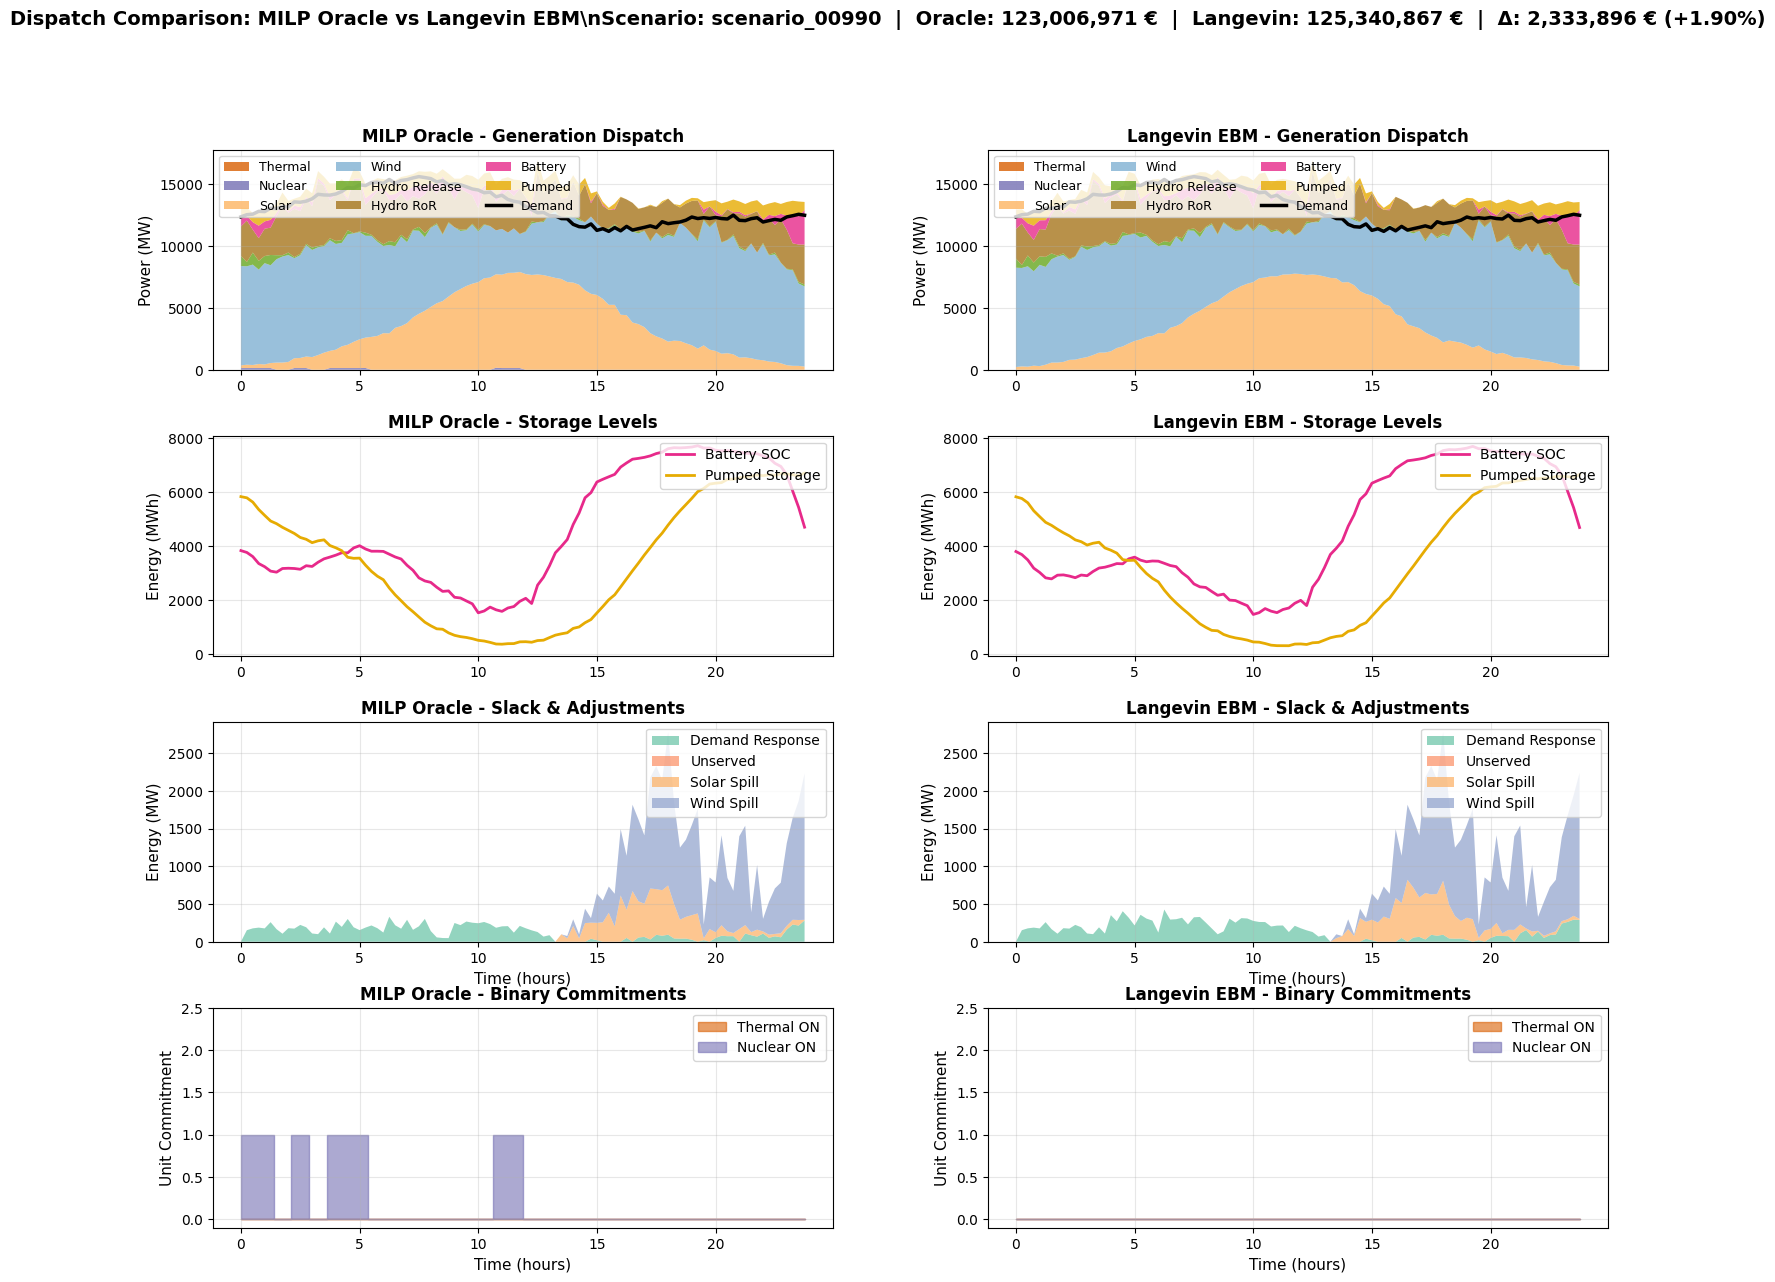

  ✓ Plot saved!

Plotting: scenario_01627
  Oracle MILP cost: 181,067,239.15 €
  [1/2] Solving LP with Oracle binaries...
    Fixing binaries from structured dict...
    Fixed 16896 binary variables from structured dict
  Oracle LP cost: 181,067,239.15 €
  [2/2] Solving LP with Langevin binaries (candidate 0)...
    Fixing binaries from structured dict...
    Fixed 16896 binary variables from structured dict
  Langevin LP cost: 181,067,239.15 €
  Cost difference: 0.00 € (+0.00%)

  Generating plot...


/tmp/ipython-input-4280898806.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Plot saved to: /content/drive/MyDrive/benchmark/outputs/comparison_plots/scenario_01627_comparison.png


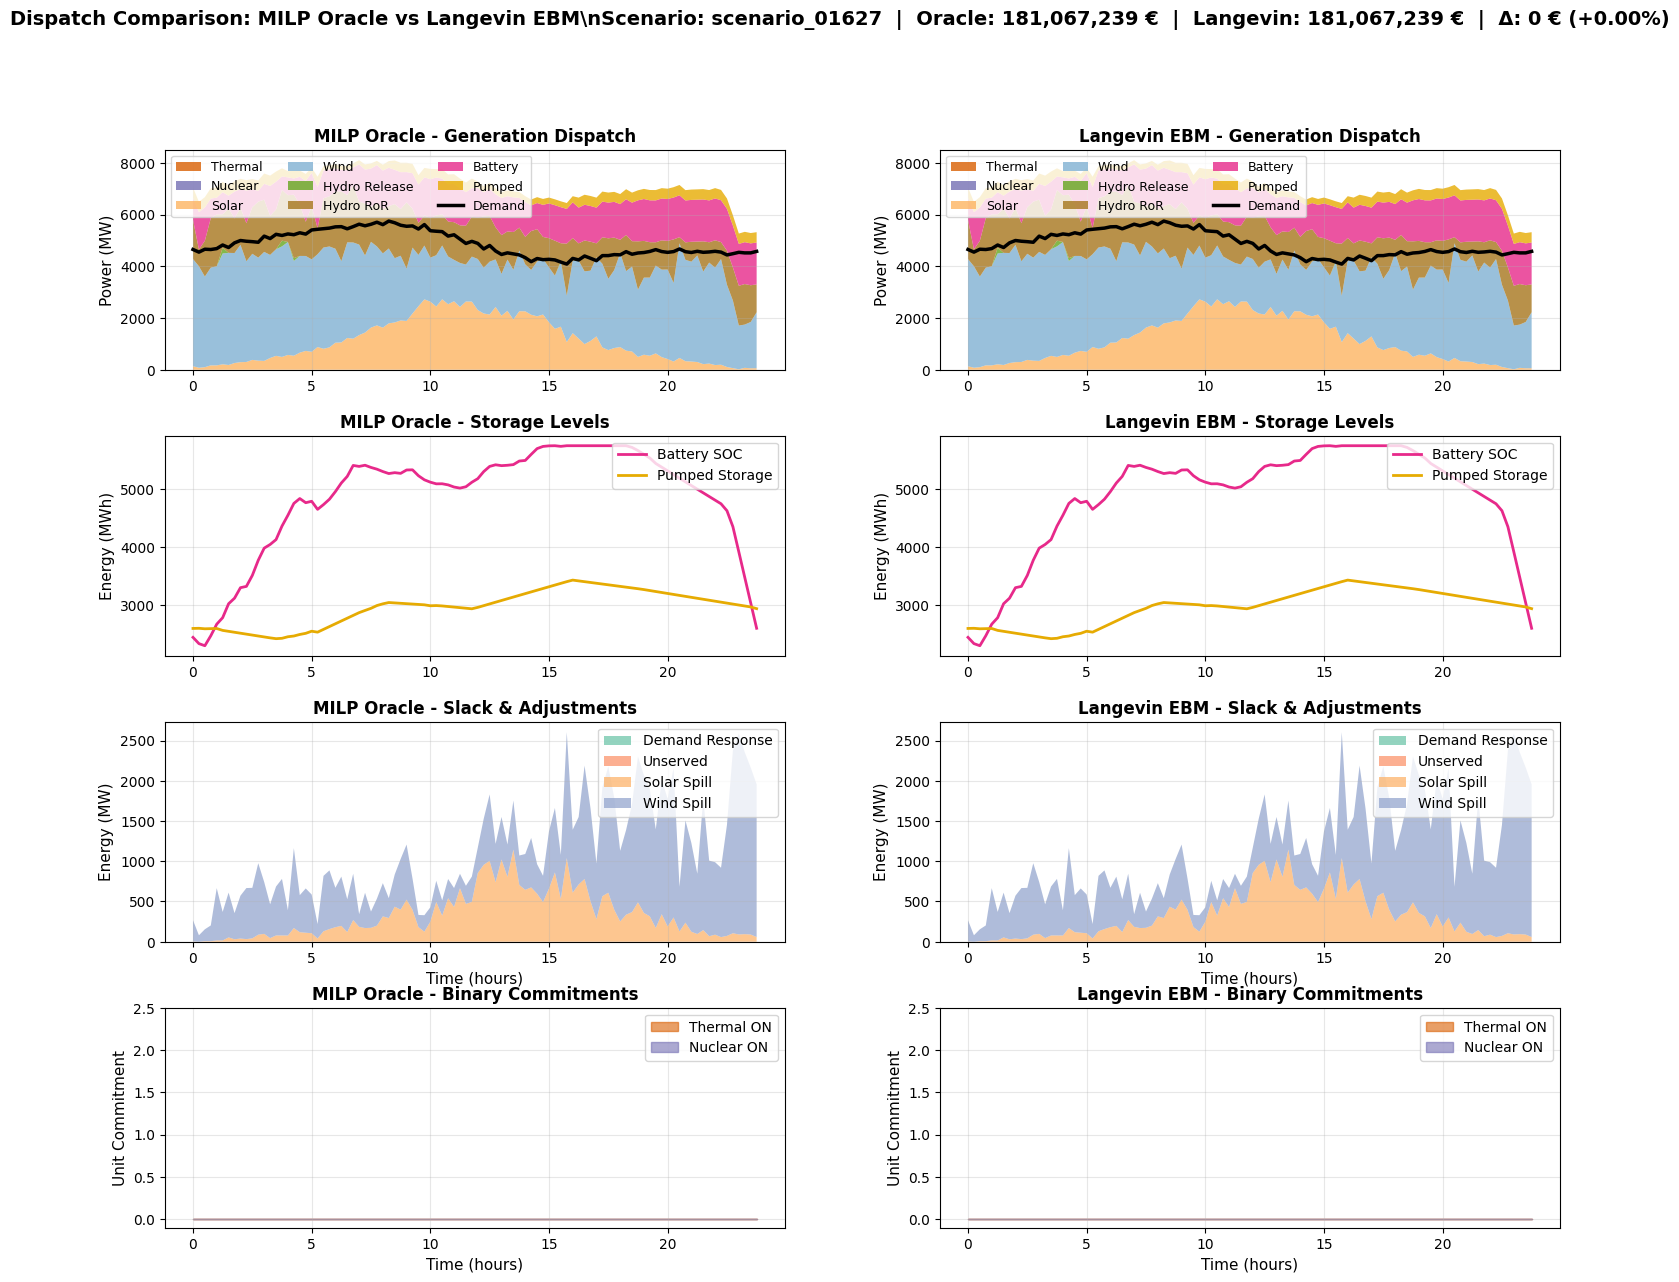

  ✓ Plot saved!

Plotting: scenario_01998
  Oracle MILP cost: 5,723,714.34 €
  [1/2] Solving LP with Oracle binaries...
    Fixing binaries from structured dict...
    Fixed 13056 binary variables from structured dict
  Oracle LP cost: 5,723,714.34 €
  [2/2] Solving LP with Langevin binaries (candidate 0)...
    Fixing binaries from structured dict...
    Fixed 13056 binary variables from structured dict
  Langevin LP cost: 5,723,714.34 €
  Cost difference: 0.00 € (+0.00%)

  Generating plot...


/tmp/ipython-input-4280898806.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Plot saved to: /content/drive/MyDrive/benchmark/outputs/comparison_plots/scenario_01998_comparison.png


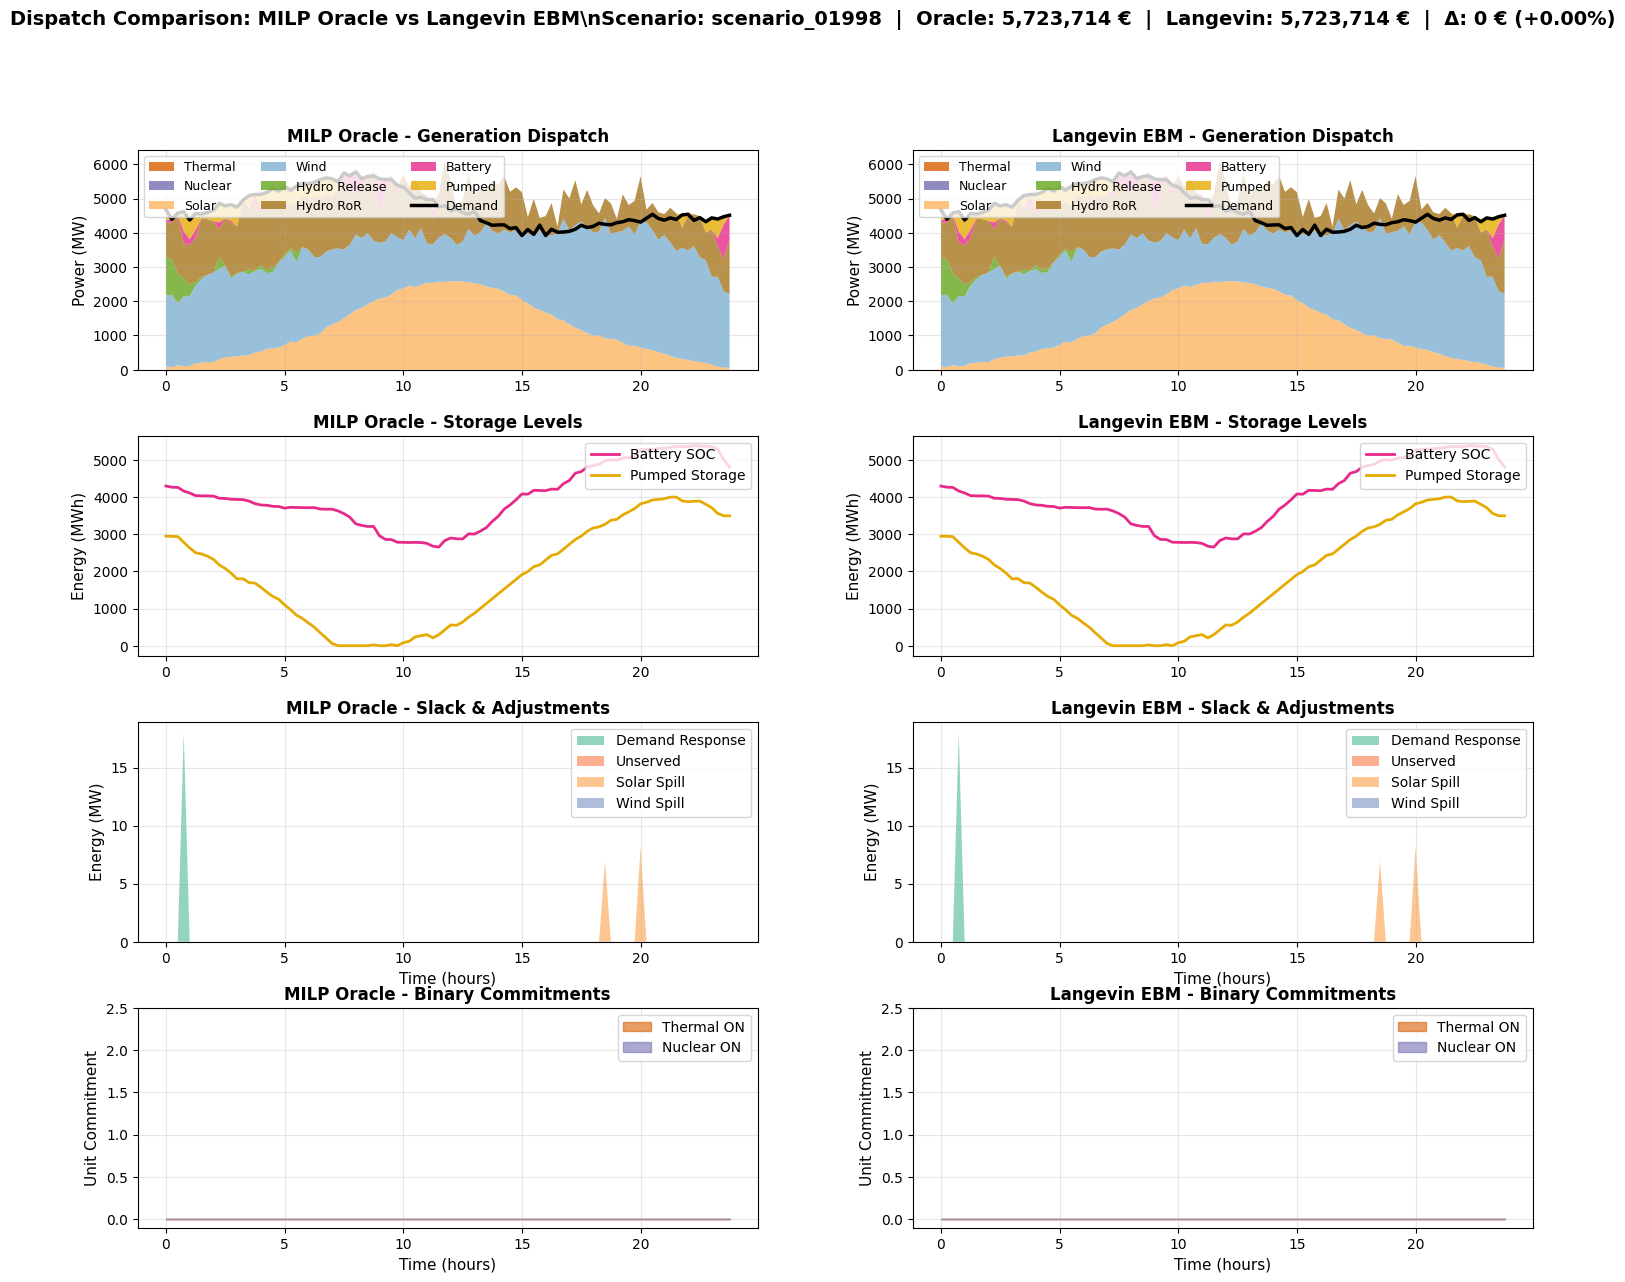

  ✓ Plot saved!

PLOTTING COMPLETE
Output directory: /content/drive/MyDrive/benchmark/outputs/comparison_plots
Generated comparison plots for 3 scenarios


In [37]:
"""
Generate comparison plots for all evaluated scenarios.
This cell will create visual comparisons between MILP Oracle and Langevin solutions.
"""

# Import necessary MILP solving functions
from src.milp.solve import solve_scenario
from src.milp.scenario_loader import load_scenario_data, ScenarioData

print("="*80)
print("GENERATING DISPATCH COMPARISON PLOTS")
print("="*80)

# Directory to save plots
plot_output_dir = Path(REPO_PATH) / "outputs" / "comparison_plots"
plot_output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {plot_output_dir}\n")

# We'll visualize a few scenarios from the evaluation
# Using scenario IDs from all_results generated in previous cell
scenarios_to_plot = [res['scenario_id'] for res in all_results[:3]]  # First 3 scenarios

for result in all_results:
    scenario_id = result['scenario_id']

    # Skip if not in our plot list
    if scenario_id not in scenarios_to_plot:
        continue

    print(f"\n{'='*80}")
    print(f"Plotting: {scenario_id}")
    print(f"{'='*80}")

    scenario_json_path = Path(REPO_PATH) / SCENARIOS_DIR / f"{scenario_id}.json"
    complete_json_path = Path(REPO_PATH) / SCENARIO_DIR_EVAL / f"{scenario_id}_complete.json"

    if not scenario_json_path.exists():
        print(f"  ⚠️  Scenario file not found: {scenario_json_path}")
        continue

    if not complete_json_path.exists():
        print(f"  ⚠️  Complete solution not found: {complete_json_path}")
        continue

    # Load scenario data for conversion
    scenario_data = load_scenario_data(scenario_json_path)

    # Load Oracle binaries from complete solution
    with open(complete_json_path, 'r') as f:
        complete_data = json.load(f)

    oracle_binaries = complete_data['variables']['binary_variables']
    oracle_mip_cost = complete_data['mip_solution']['objective']

    print(f"  Oracle MILP cost: {oracle_mip_cost:,.2f} €")

    # Solve LP with Oracle binaries to get dispatch details
    print(f"  [1/2] Solving LP with Oracle binaries...")
    oracle_lp_result = solve_lp_with_commitment(
        str(scenario_json_path),
        binary_dict=oracle_binaries
    )

    if oracle_lp_result['termination'] != 'optimal':
        print(f"  ⚠️  Oracle LP not optimal: {oracle_lp_result['termination']}")
        continue

    oracle_lp_cost = oracle_lp_result['objective']
    oracle_detail = oracle_lp_result['detail']

    if oracle_detail is None:
        print(f"  ⚠️  No dispatch detail returned - skipping visualization")
        continue

    print(f"  Oracle LP cost: {oracle_lp_cost:,.2f} €")

    # Get Langevin candidate binaries (best energy)
    best_idx = result['best_candidate_idx']
    best_candidate = result['candidates'][best_idx]  # This is a tensor

    # Convert to MILP format
    print(f"  [2/2] Solving LP with Langevin binaries (candidate {best_idx})...")

    # Convert from dataset format (7 bins) to MILP format (4 bins)
    langevin_binaries_milp = convert_langevin_to_milp_binaries(
        best_candidate,
        scenario_data  # ← FIX: Use scenario_data instead of n_zones/n_timesteps
    )

    if langevin_binaries_milp is None:
        print(f"  ⚠️  Failed to convert Langevin binaries - skipping")
        continue

    # Solve LP with Langevin binaries
    langevin_lp_result = solve_lp_with_commitment(
        str(scenario_json_path),
        binary_dict=langevin_binaries_milp
    )

    if langevin_lp_result['termination'] != 'optimal':
        print(f"  ⚠️  Langevin LP not optimal: {langevin_lp_result['termination']}")
        continue

    langevin_lp_cost = langevin_lp_result['objective']
    langevin_detail = langevin_lp_result['detail']

    if langevin_detail is None:
        print(f"  ⚠️  No Langevin dispatch detail - skipping visualization")
        continue

    print(f"  Langevin LP cost: {langevin_lp_cost:,.2f} €")

    # Calculate cost difference
    cost_diff = langevin_lp_cost - oracle_lp_cost
    cost_pct = (cost_diff / oracle_lp_cost) * 100 if oracle_lp_cost > 0 else 0
    print(f"  Cost difference: {cost_diff:,.2f} € ({cost_pct:+.2f}%)")

    # Generate comparison plot
    plot_path = plot_output_dir / f"{scenario_id}_comparison.png"
    print(f"\n  Generating plot...")

    plot_dispatch_comparison(
        scenario_id=scenario_id,
        oracle_detail=oracle_detail,
        langevin_detail=langevin_detail,
        oracle_cost=oracle_lp_cost,
        langevin_cost=langevin_lp_cost,
        save_path=str(plot_path)
    )

    print(f"  ✓ Plot saved!")

print(f"\n{'='*80}")
print(f"PLOTTING COMPLETE")
print(f"{'='*80}")
print(f"Output directory: {plot_output_dir}")
print(f"Generated comparison plots for {len(scenarios_to_plot)} scenarios")
print("="*80)